In [1]:
import copy
from pathlib import Path
import warnings
import random

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
model_paths = ["Save_File/seperate_model_holi_wkend_05_31/A.ckpt",
                "Save_File/seperate_model_holi_wkend_05_31/B.ckpt",
                "Save_File/seperate_model_holi_wkend_05_31/C.ckpt",
                "Save_File/seperate_model_holi_wkend_05_31/D.ckpt",
                "Save_File/seperate_model_holi_wkend_05_31/E.ckpt"]

input_length = 168
output_length = 24

show_graph = True
result_save = True

dataframes = []

group_name = ["A", "B", "C", "D", "E"]

for i in range(len(group_name)):
    train_dataset = pd.read_csv(f"Refined_Data/Grouped_Data/{group_name[i]}.csv", index_col=0)
    test_dataset = pd.read_csv(f"Refined_Data/Test_Grouped_Data/{group_name[i]}.csv", index_col=0)
    merged_dataset = pd.concat([train_dataset, test_dataset], ignore_index=True)
    dataframes.append(merged_dataset)

    # merged_dataset.to_csv(f"Refined_Data/Merged_Data/{group_name[i]}.csv", mode='w')

In [3]:
group = [
    [34, 40, 42, 41, 4, 10, 11, 12],
    [35, 6, 48, 27, 57, 8, 25, 56, 26, 55, 47, 13, 53, 18, 7, 17, 46],
    [31, 33, 9, 3, 1, 32],
    [29, 38, 43, 58, 15, 22, 39, 54, 23, 44, 45, 37, 52, 2, 14],
    [21, 19, 50, 49, 20, 51, 30, 36, 28, 59, 5, 60, 16, 24]
]

all_result = [[] for i in range(60)]

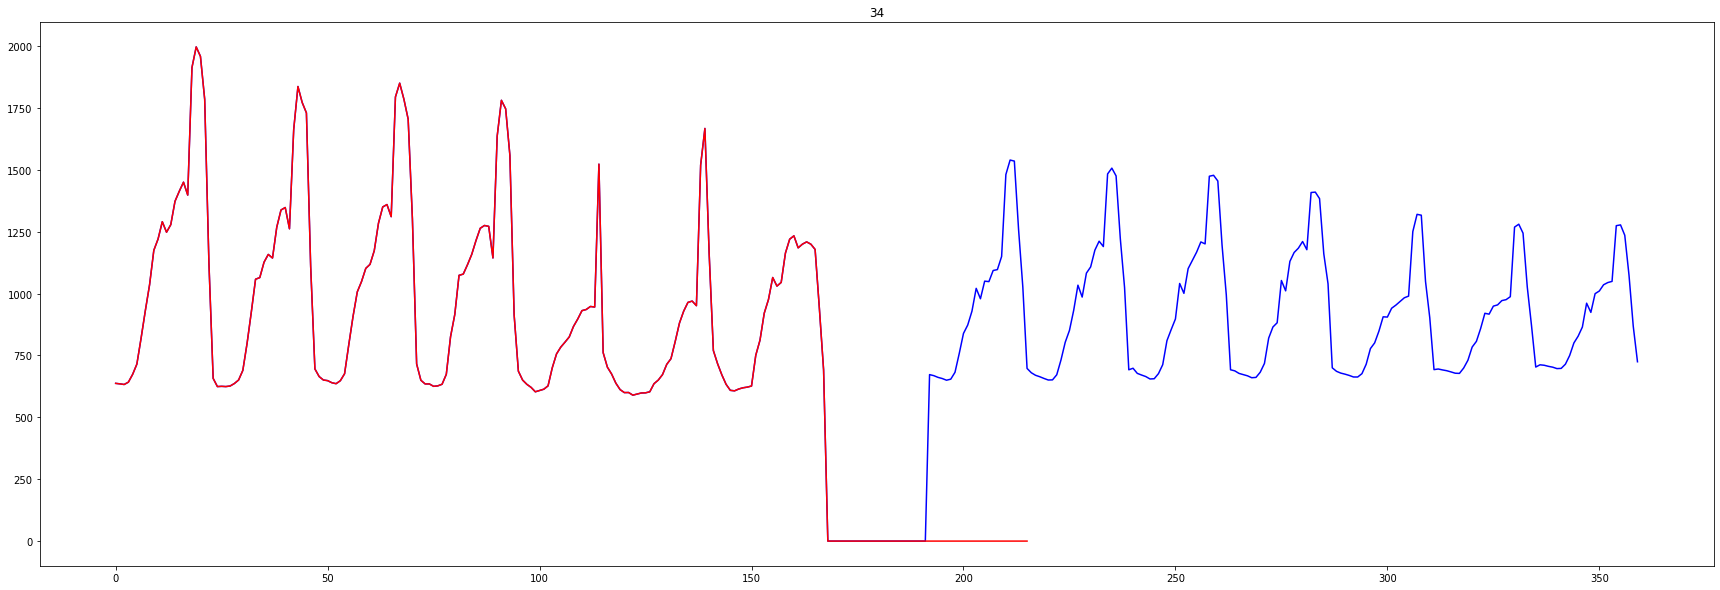

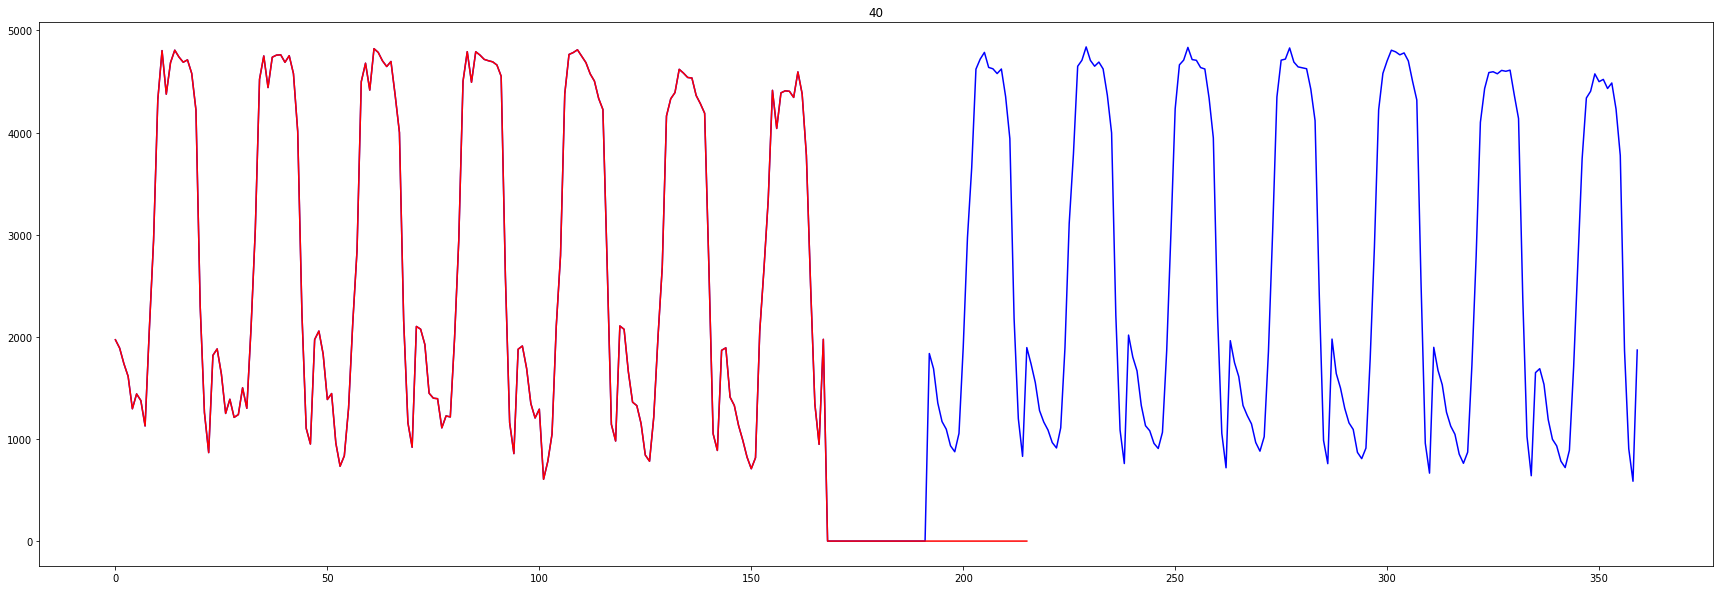

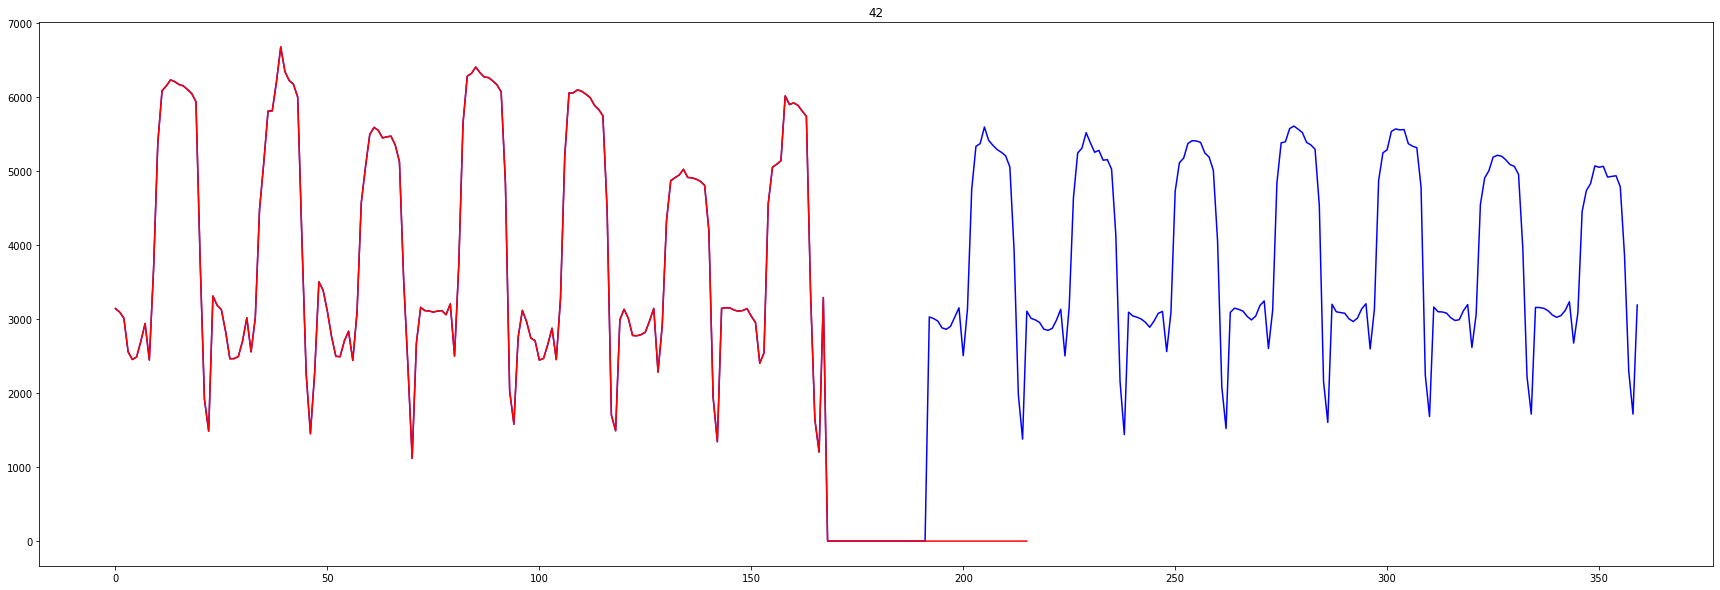

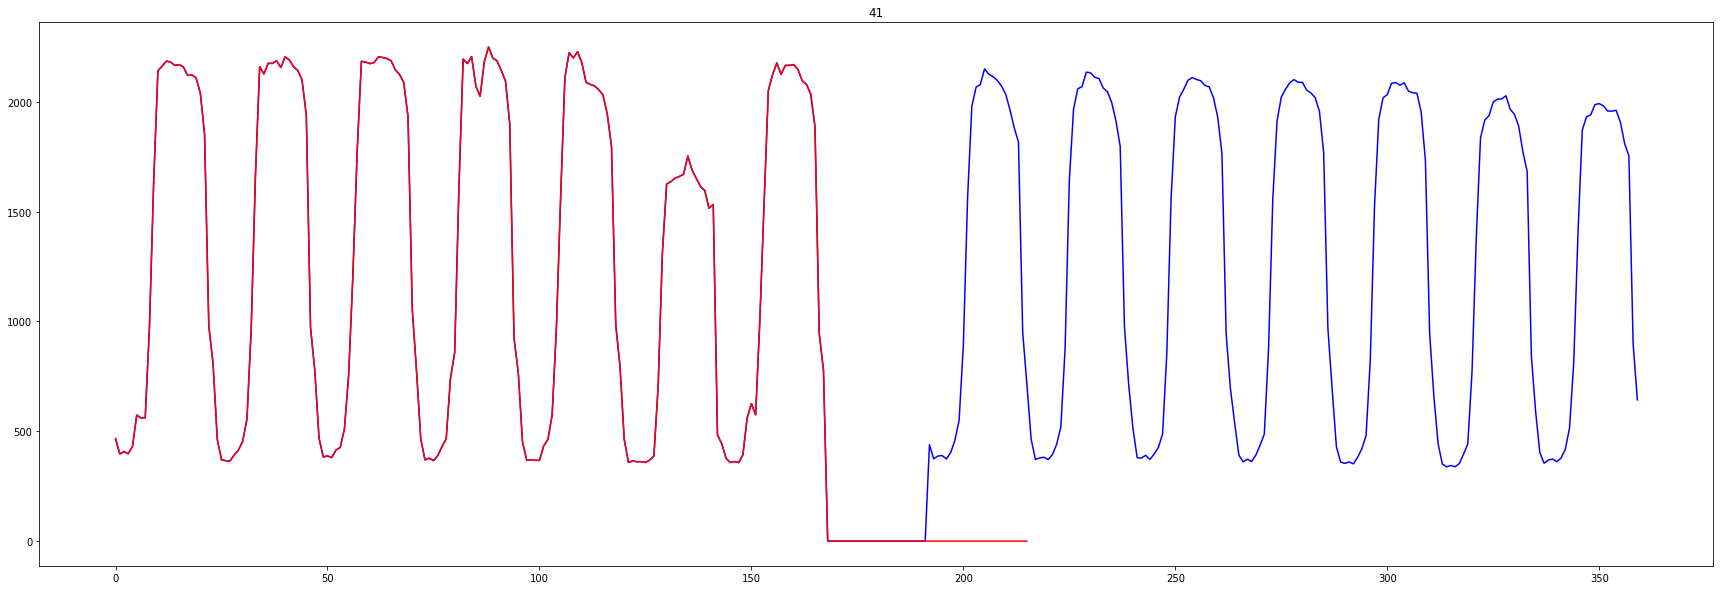

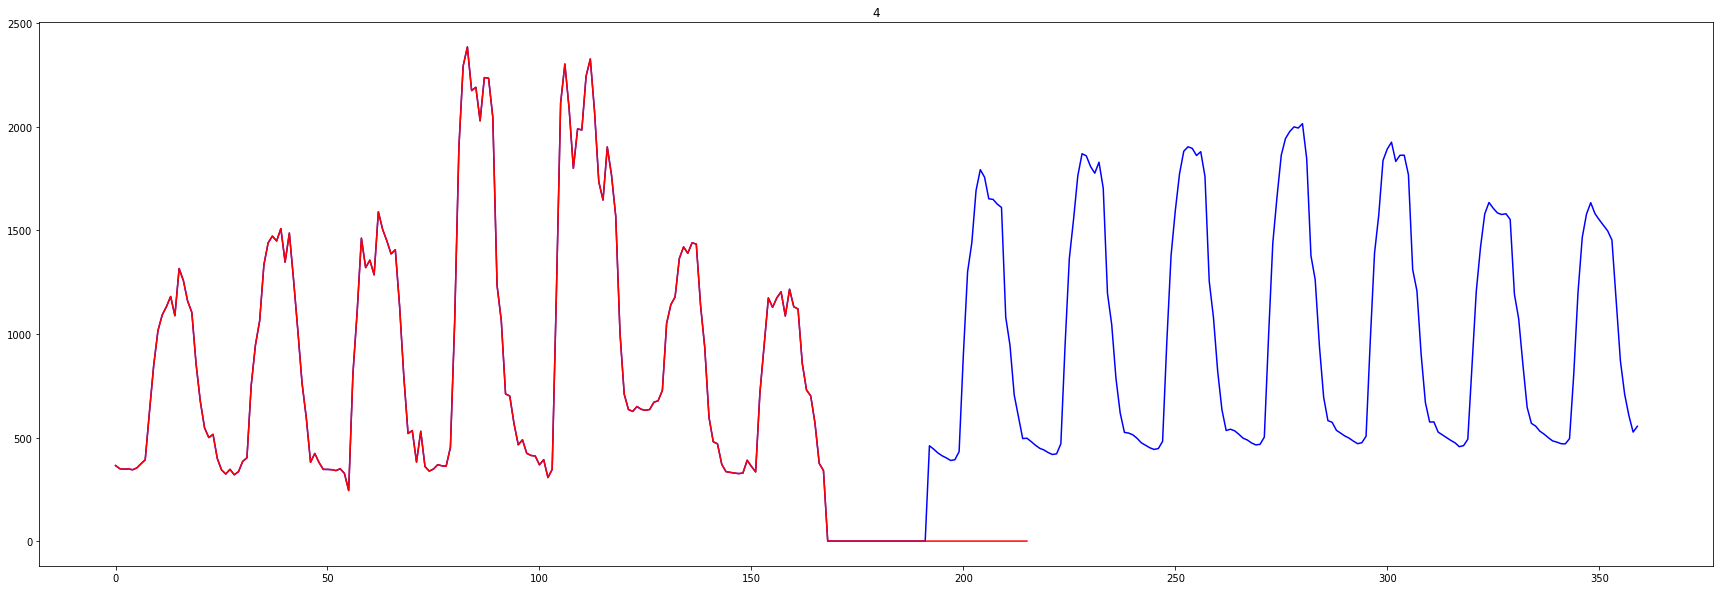

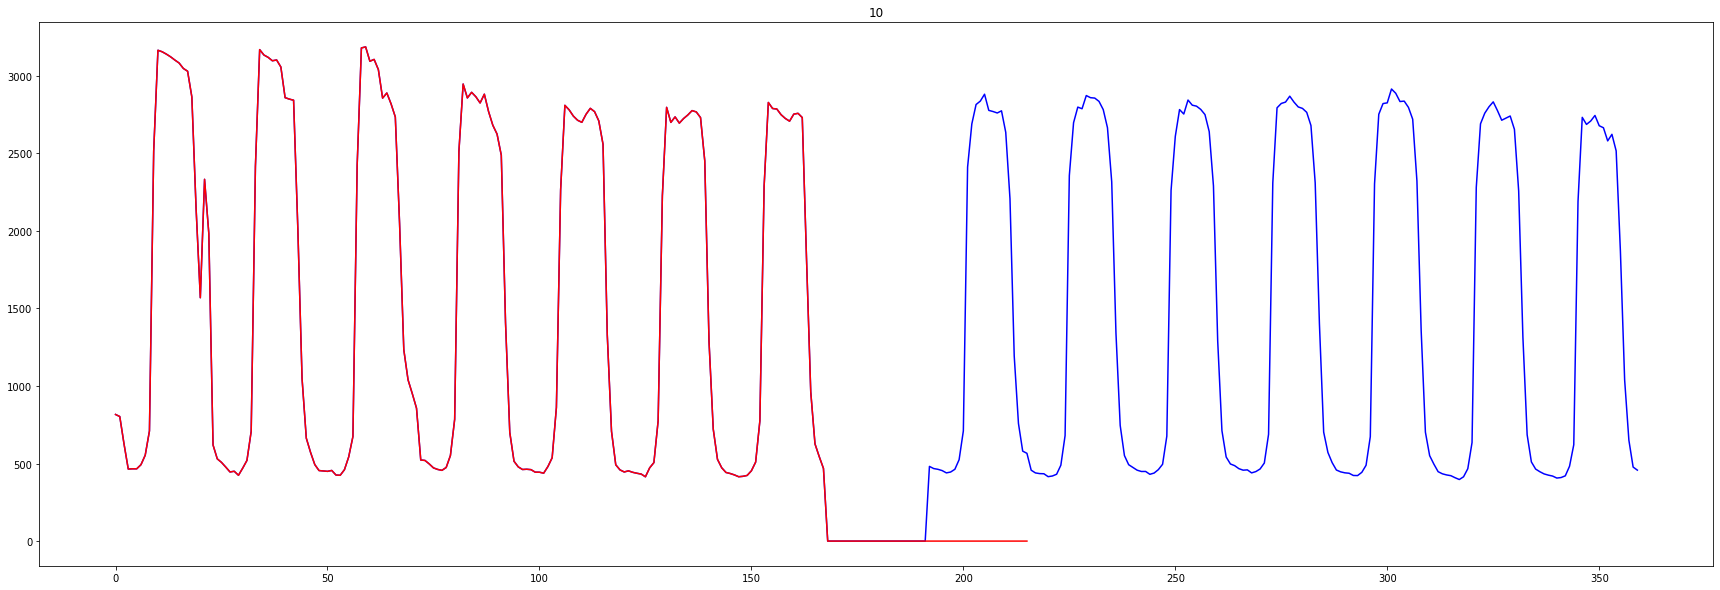

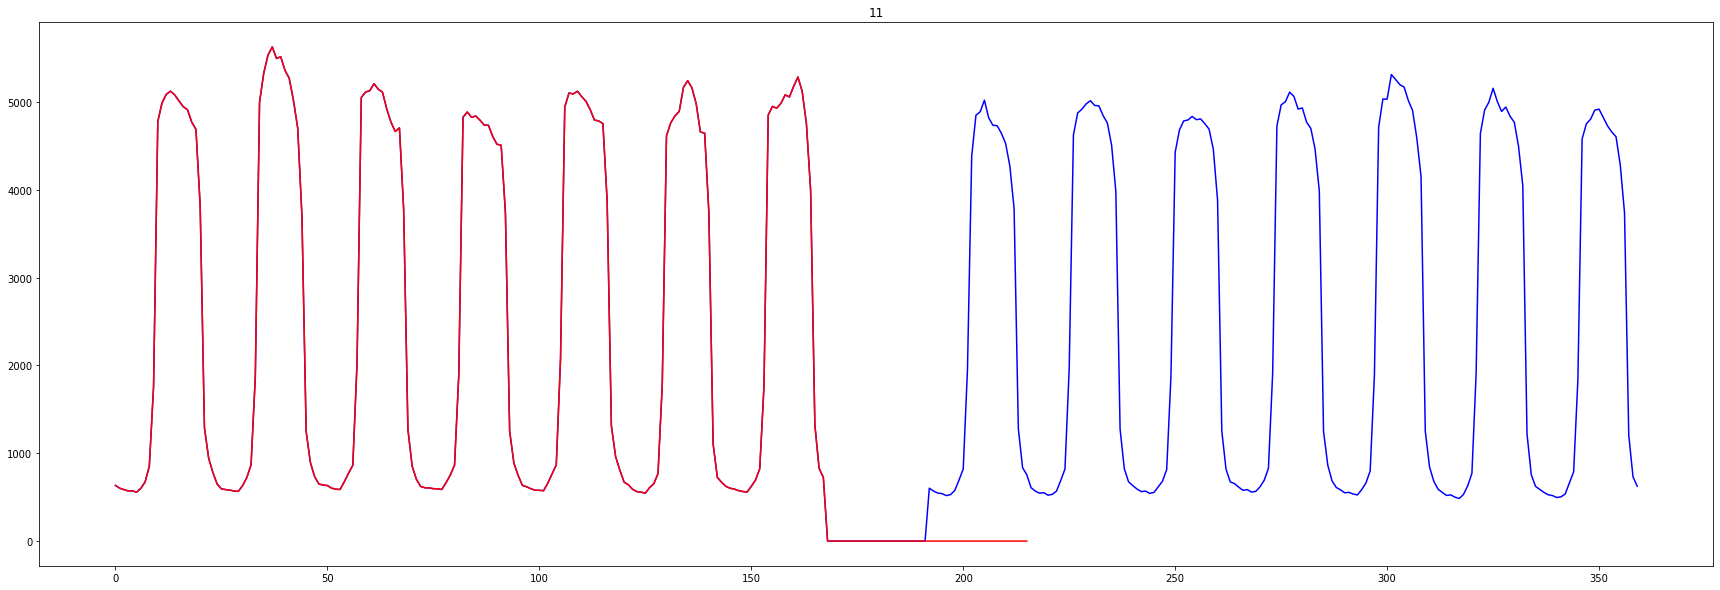

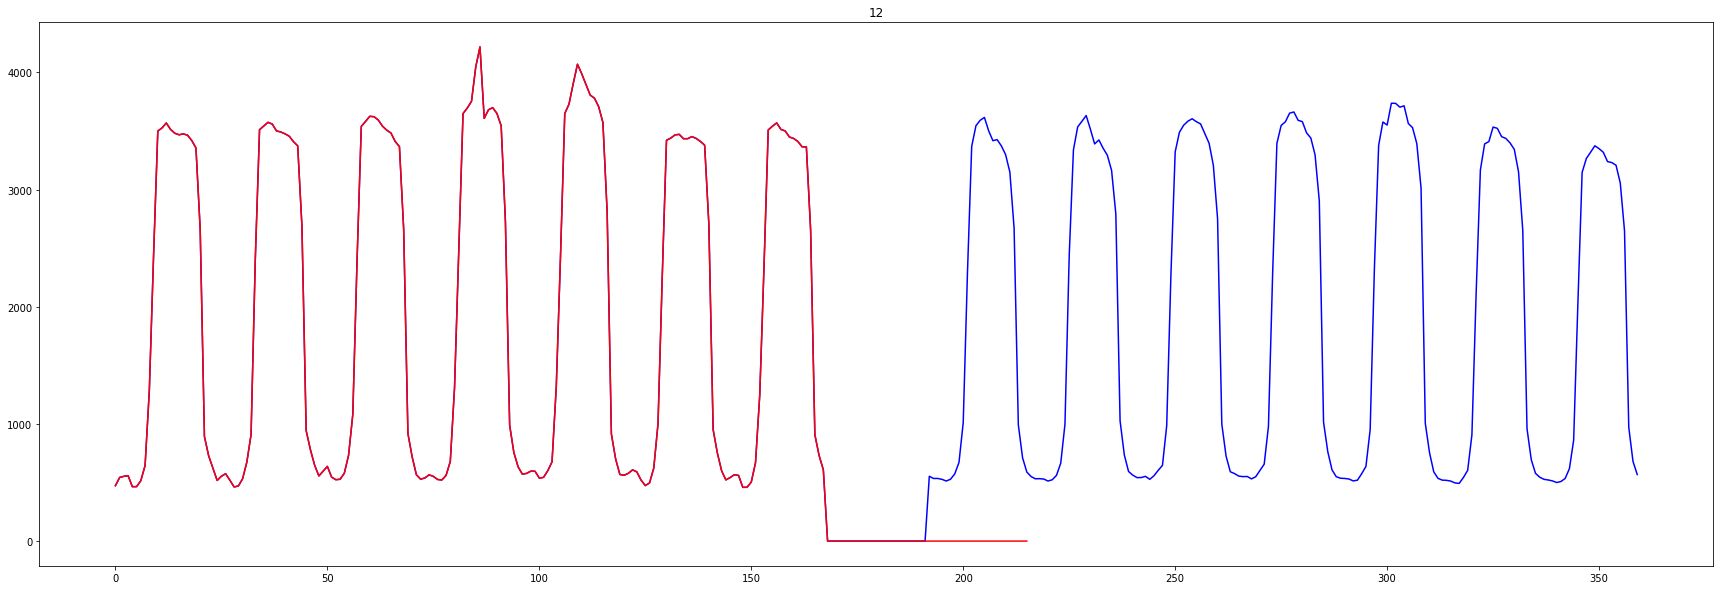

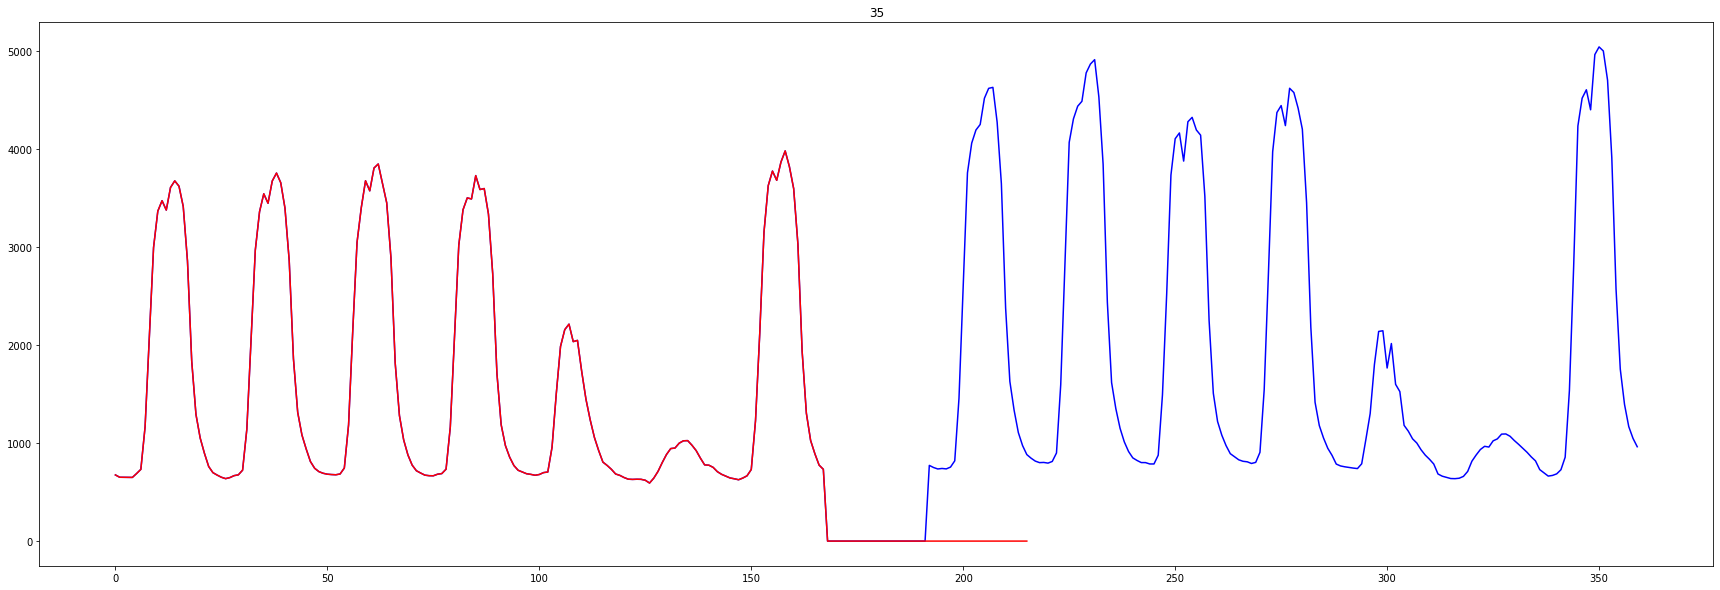

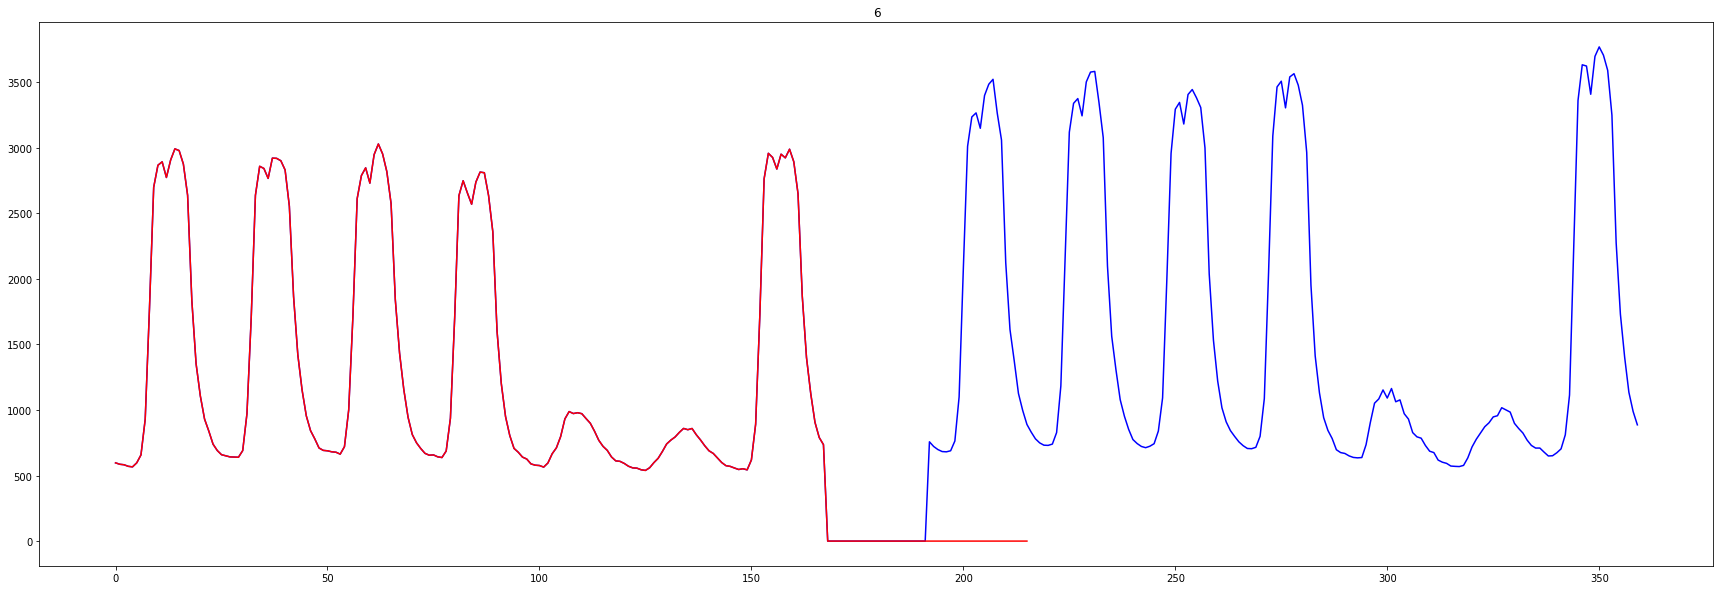

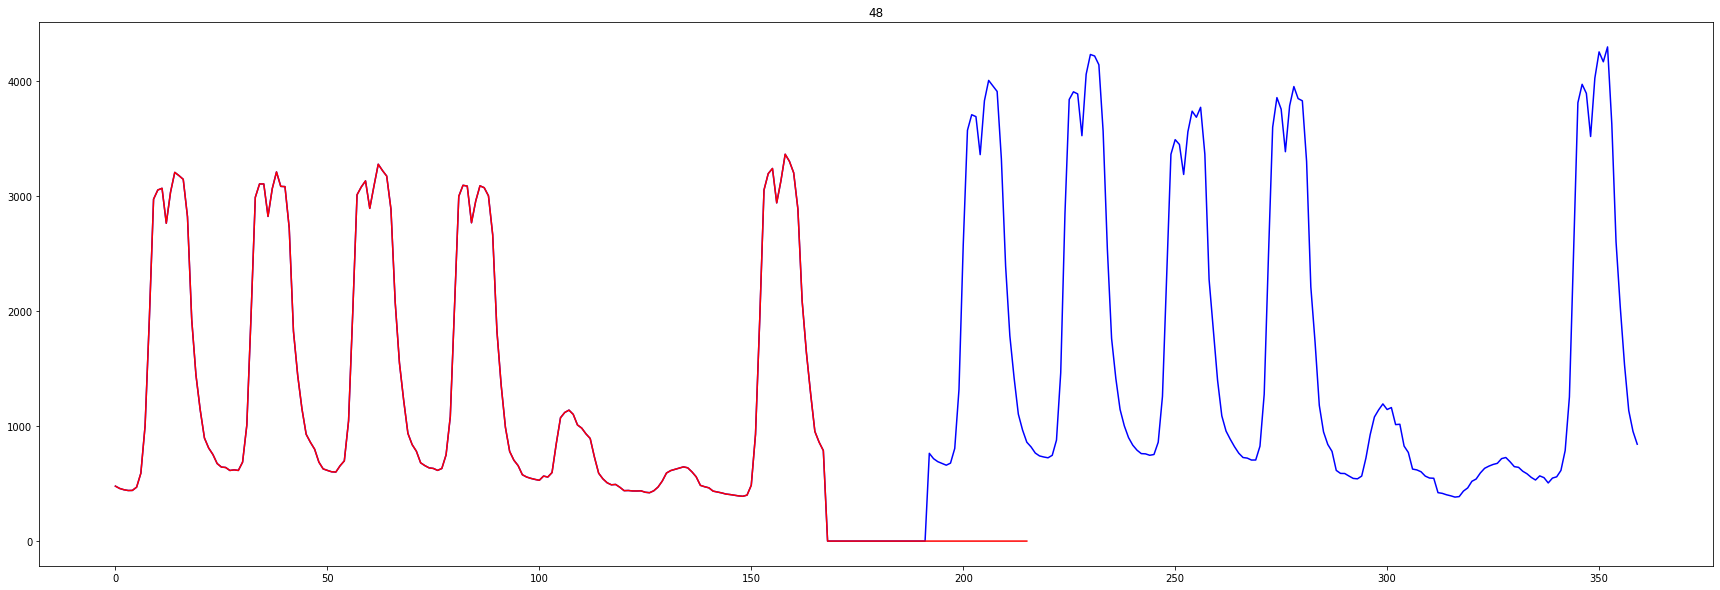

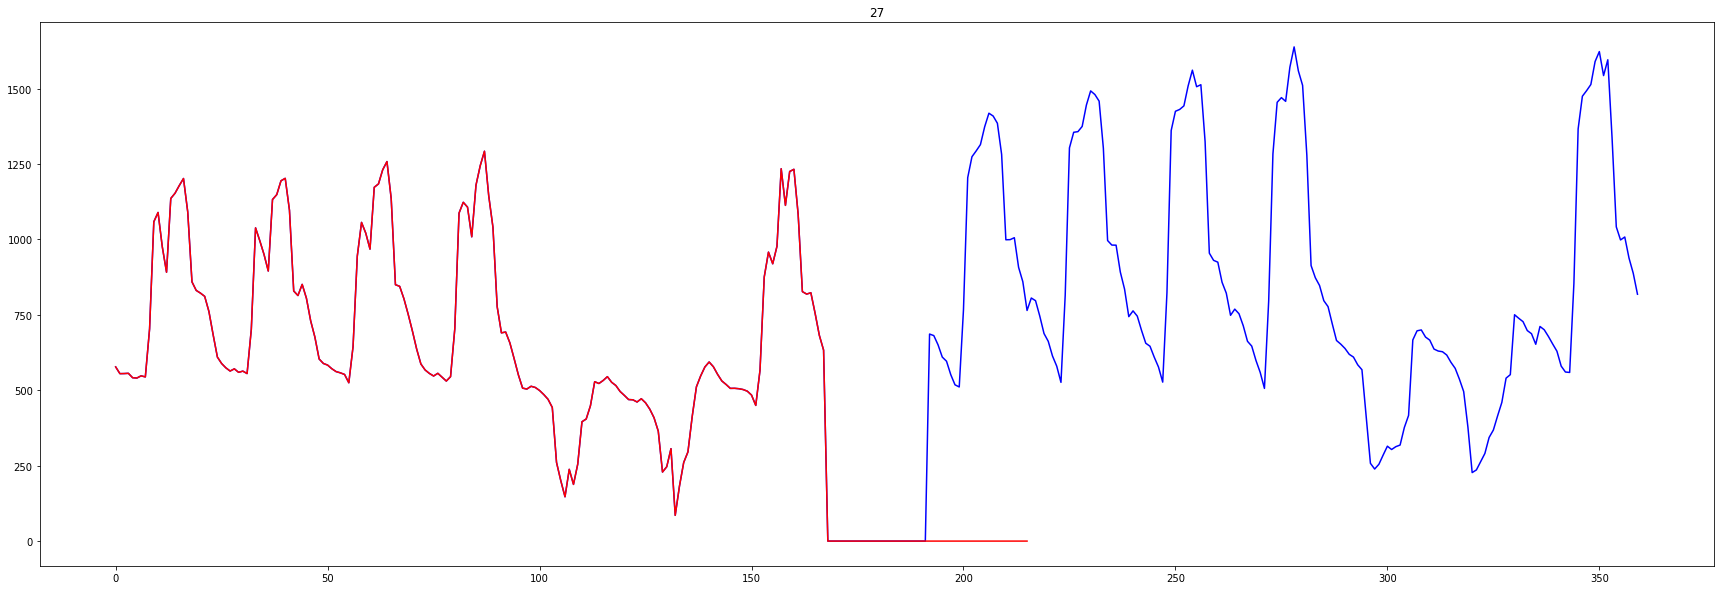

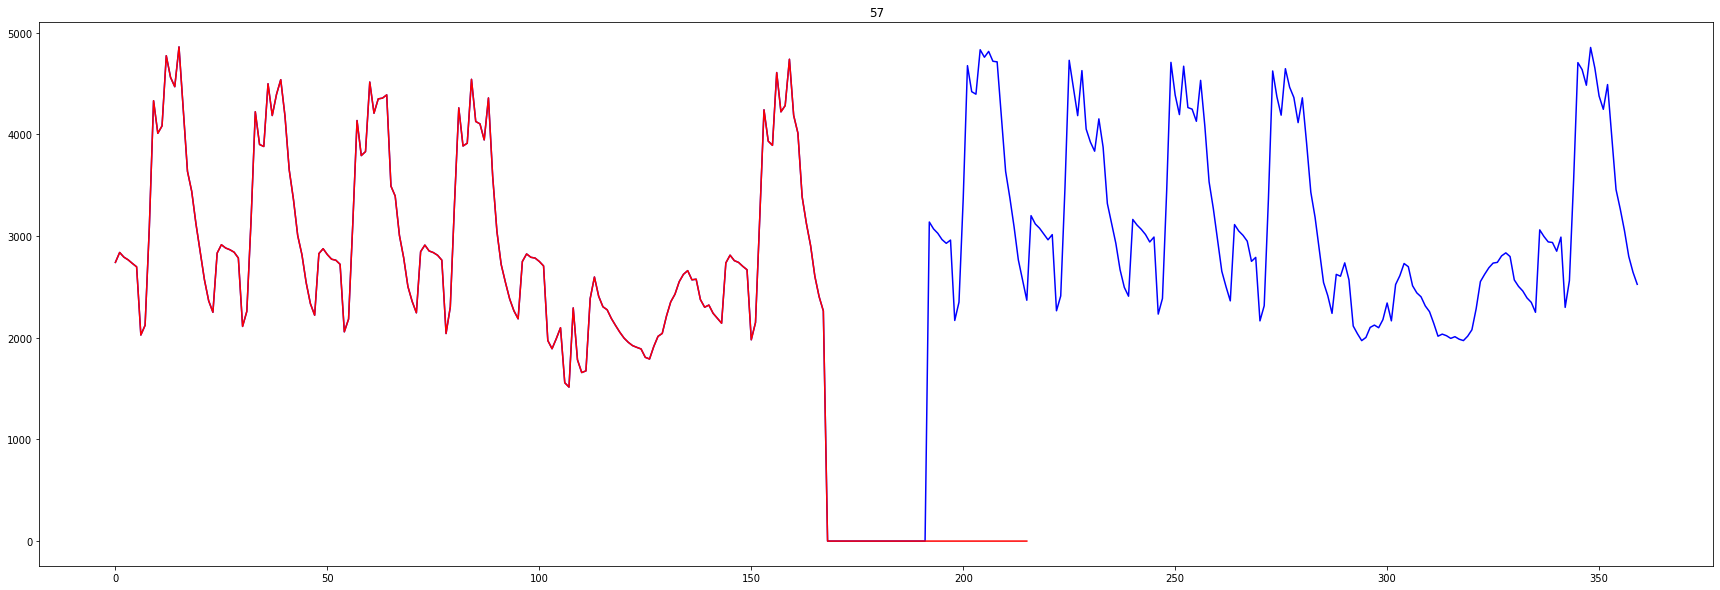

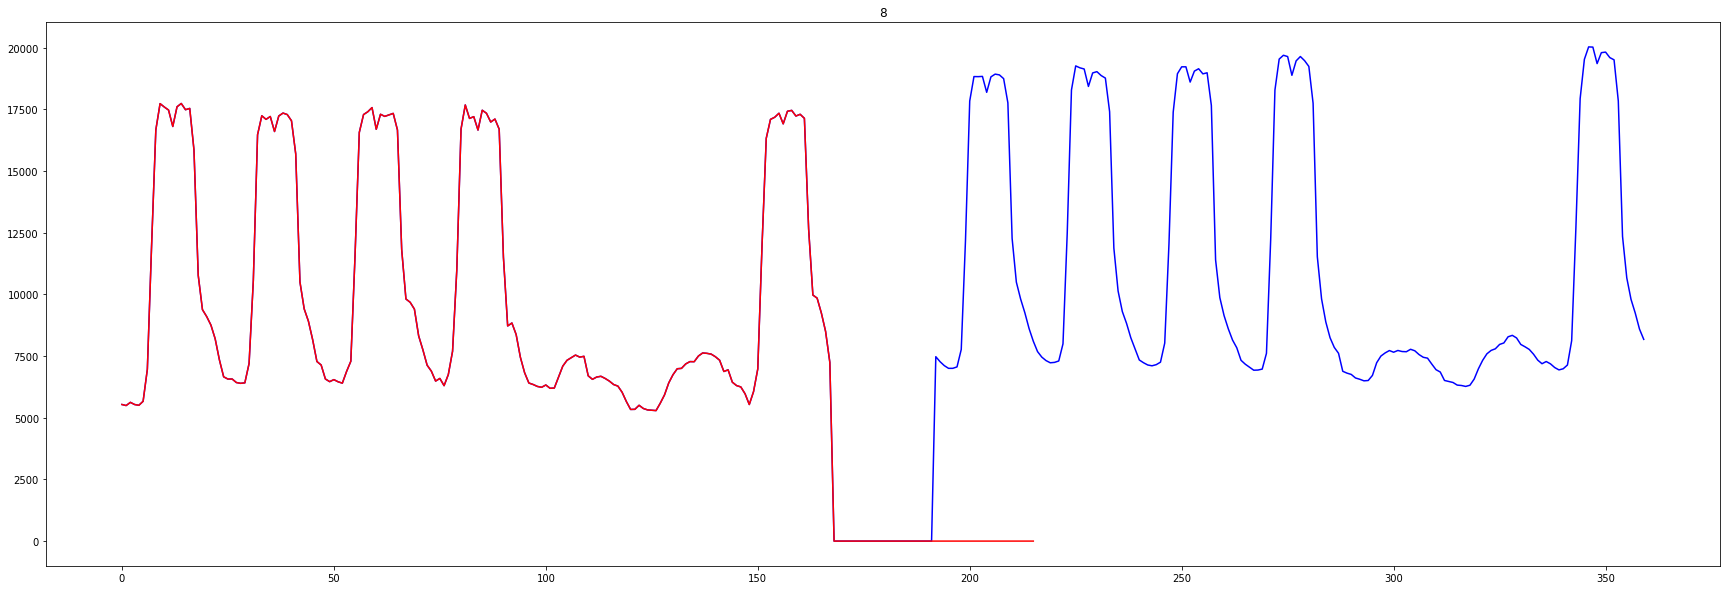

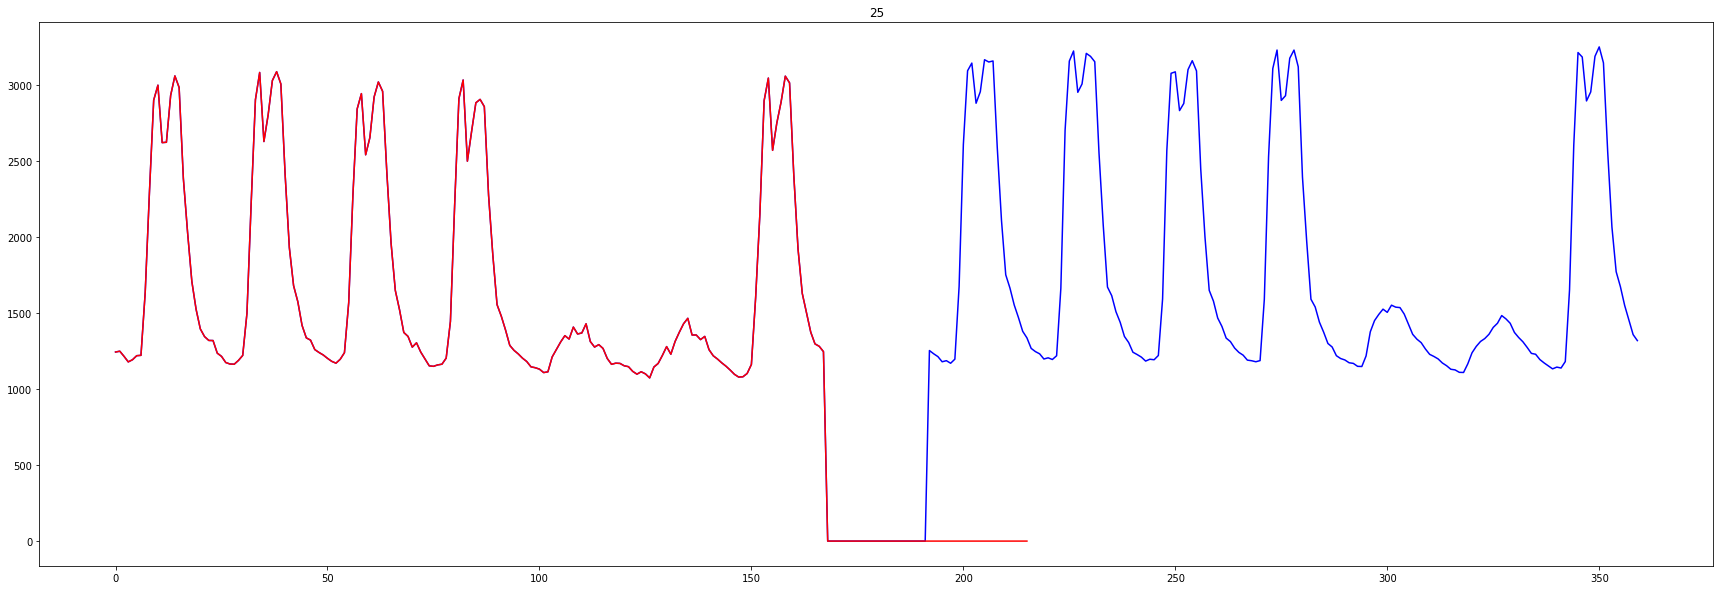

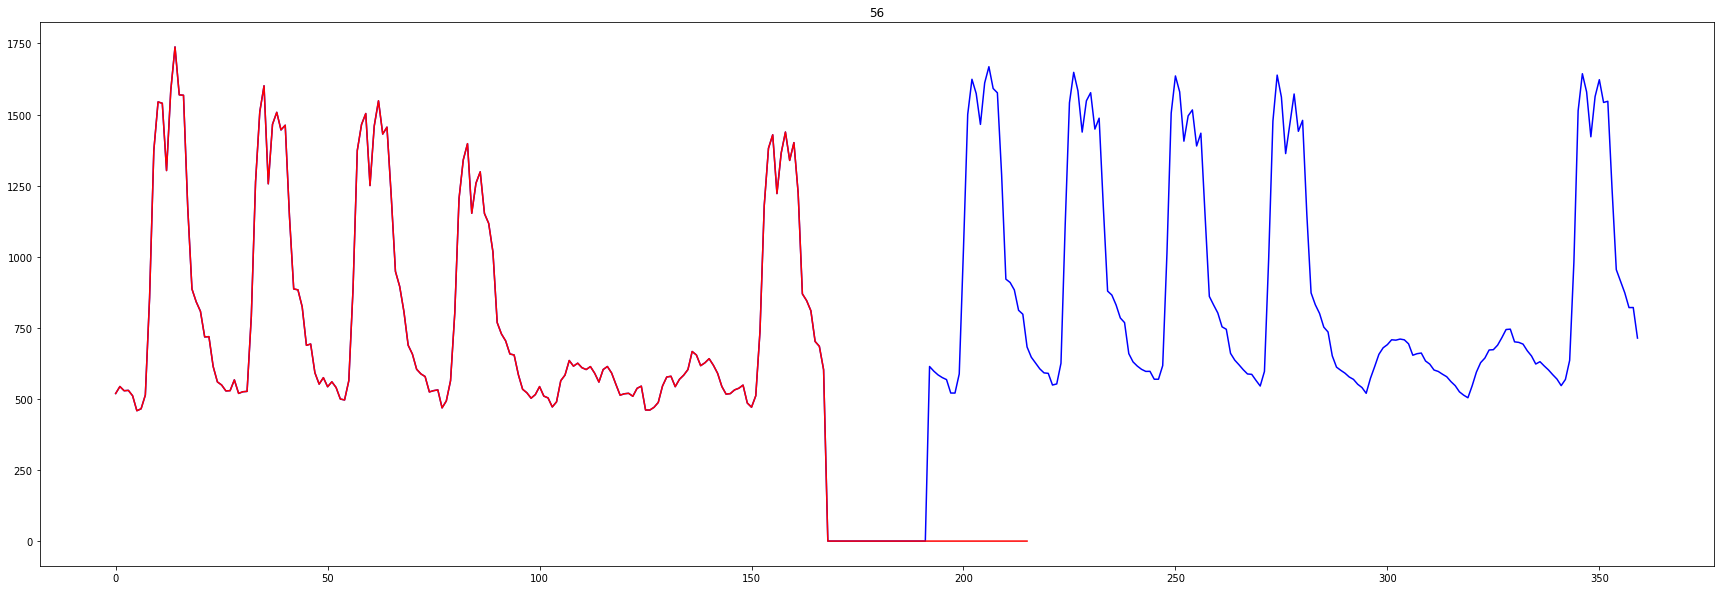

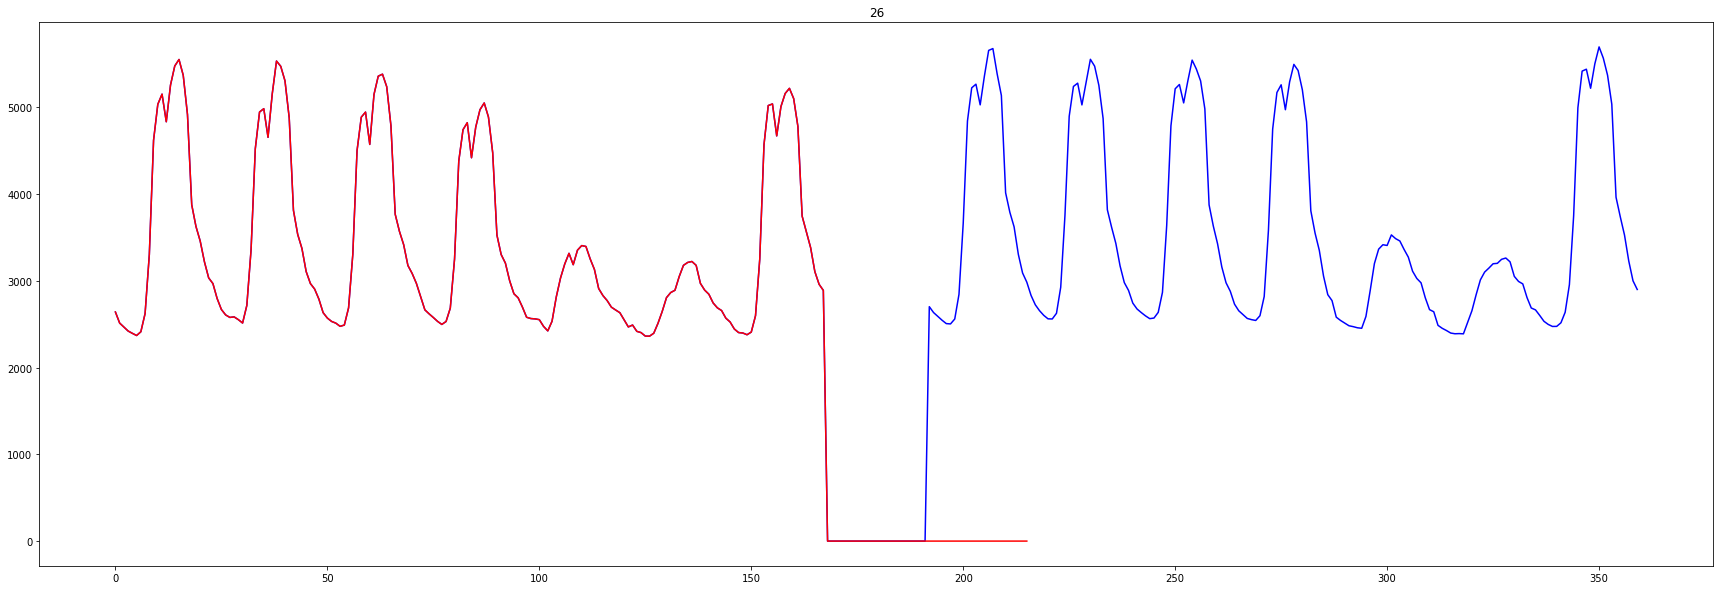

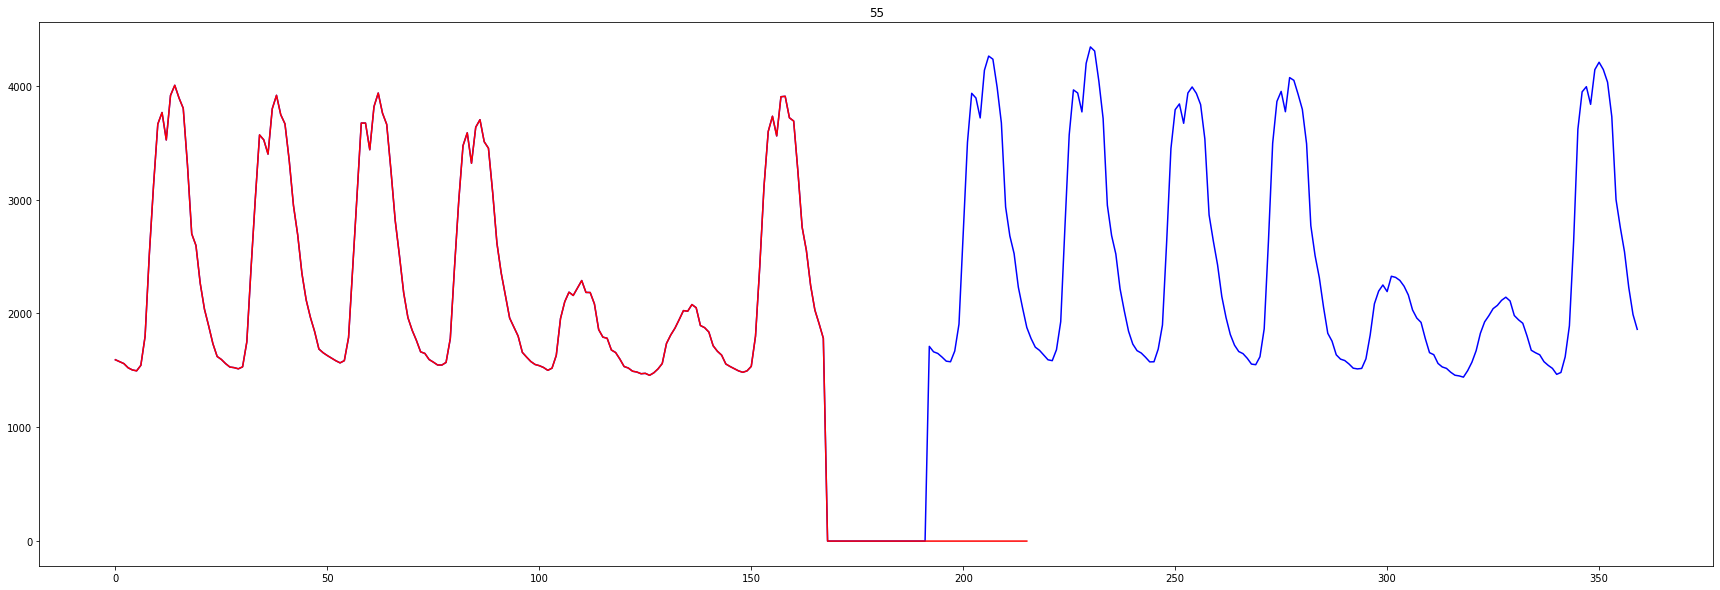

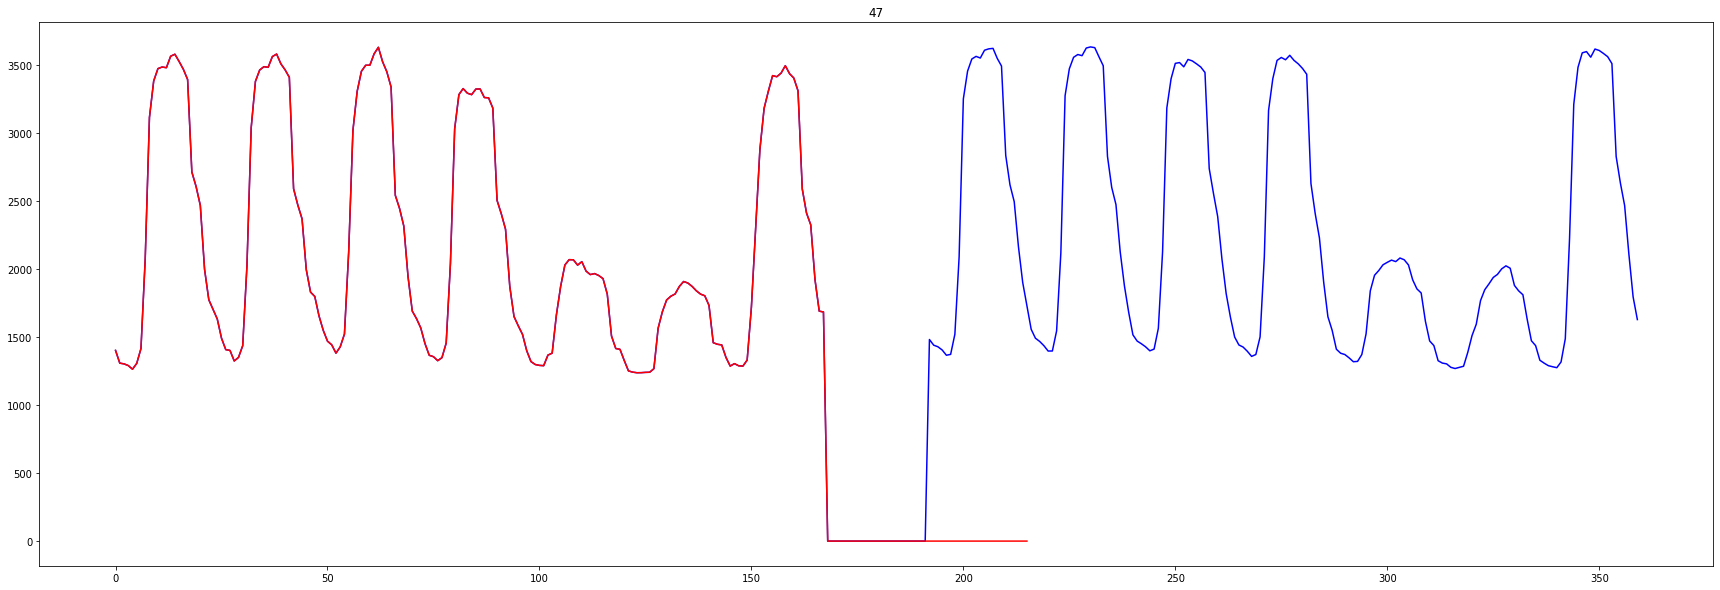

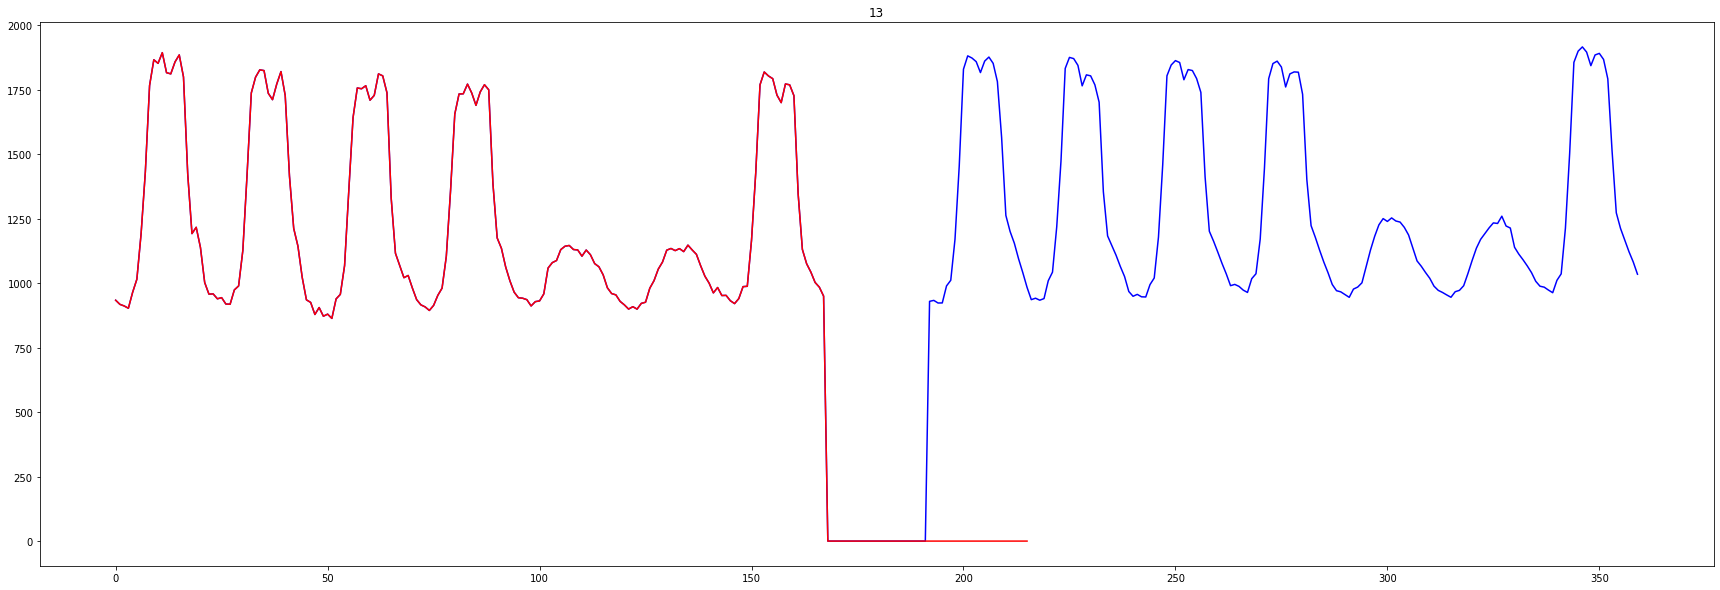

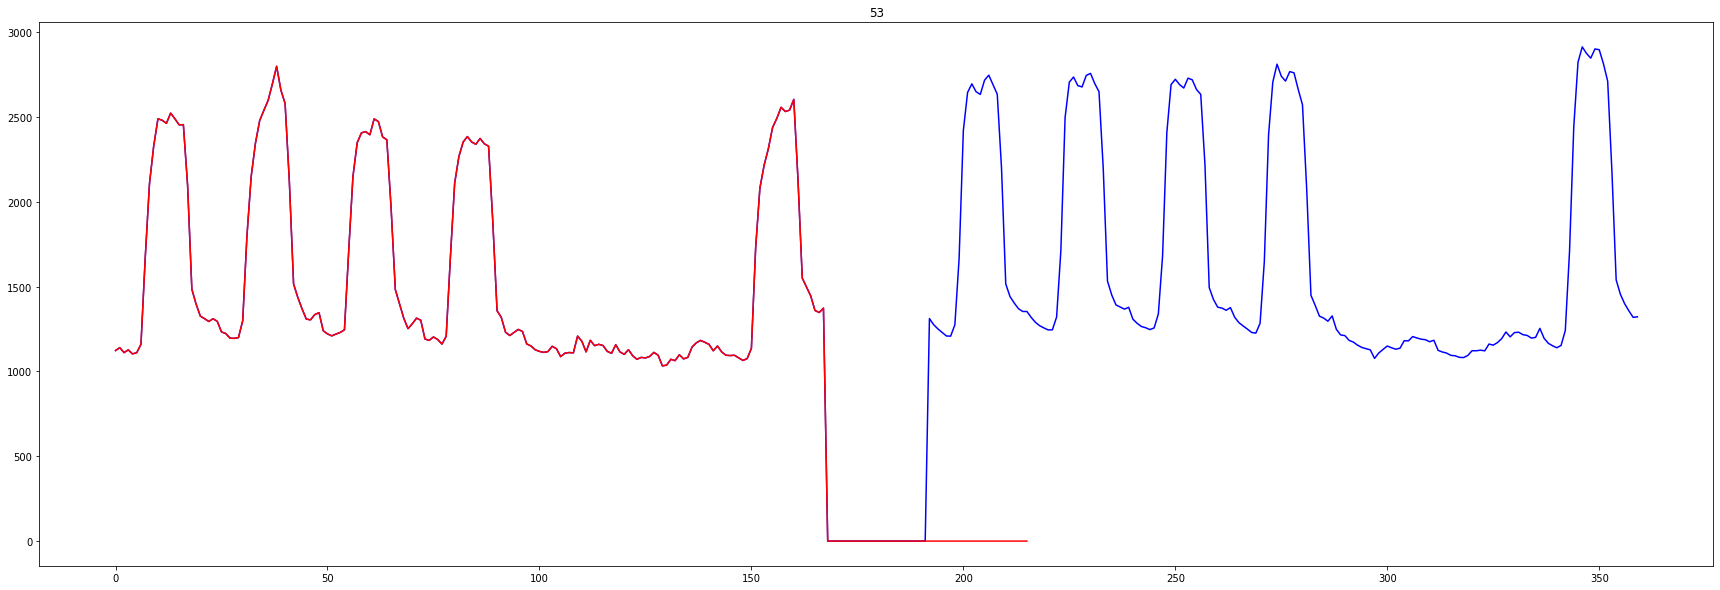

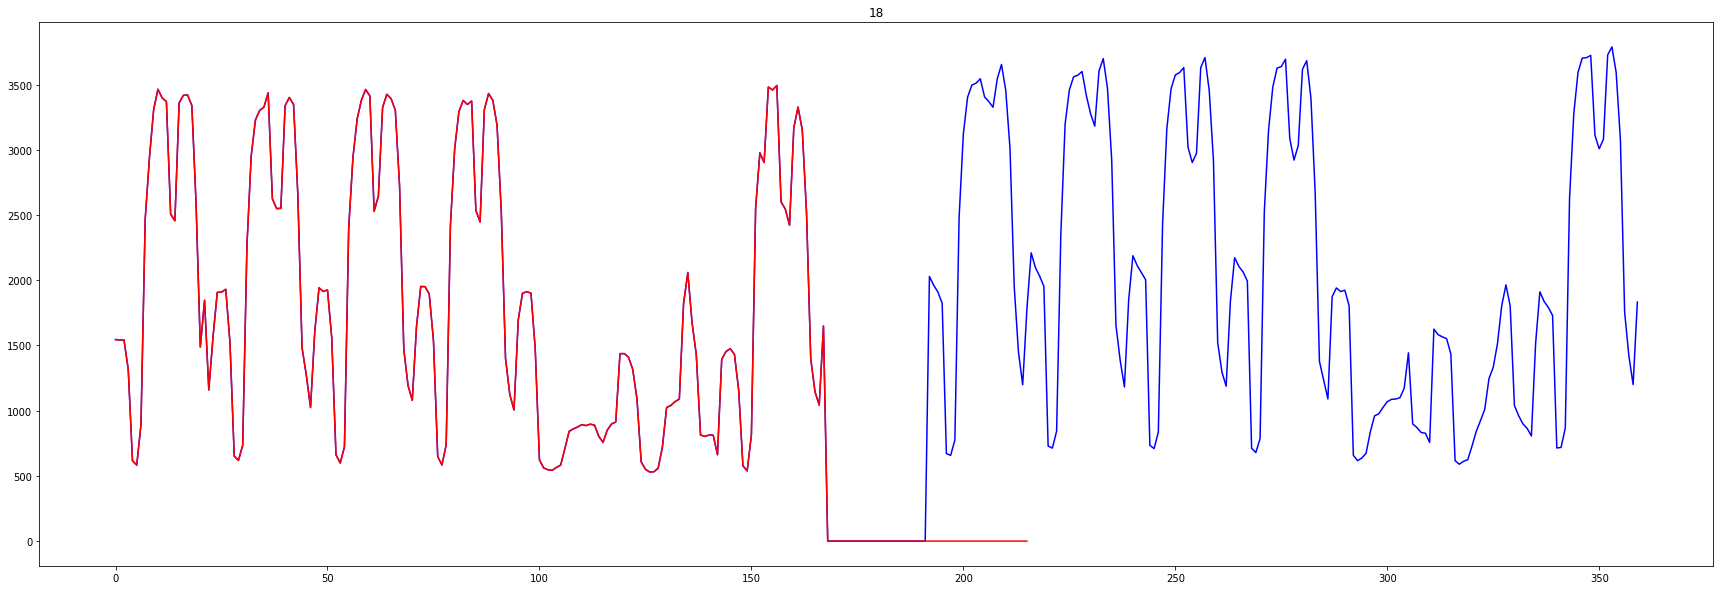

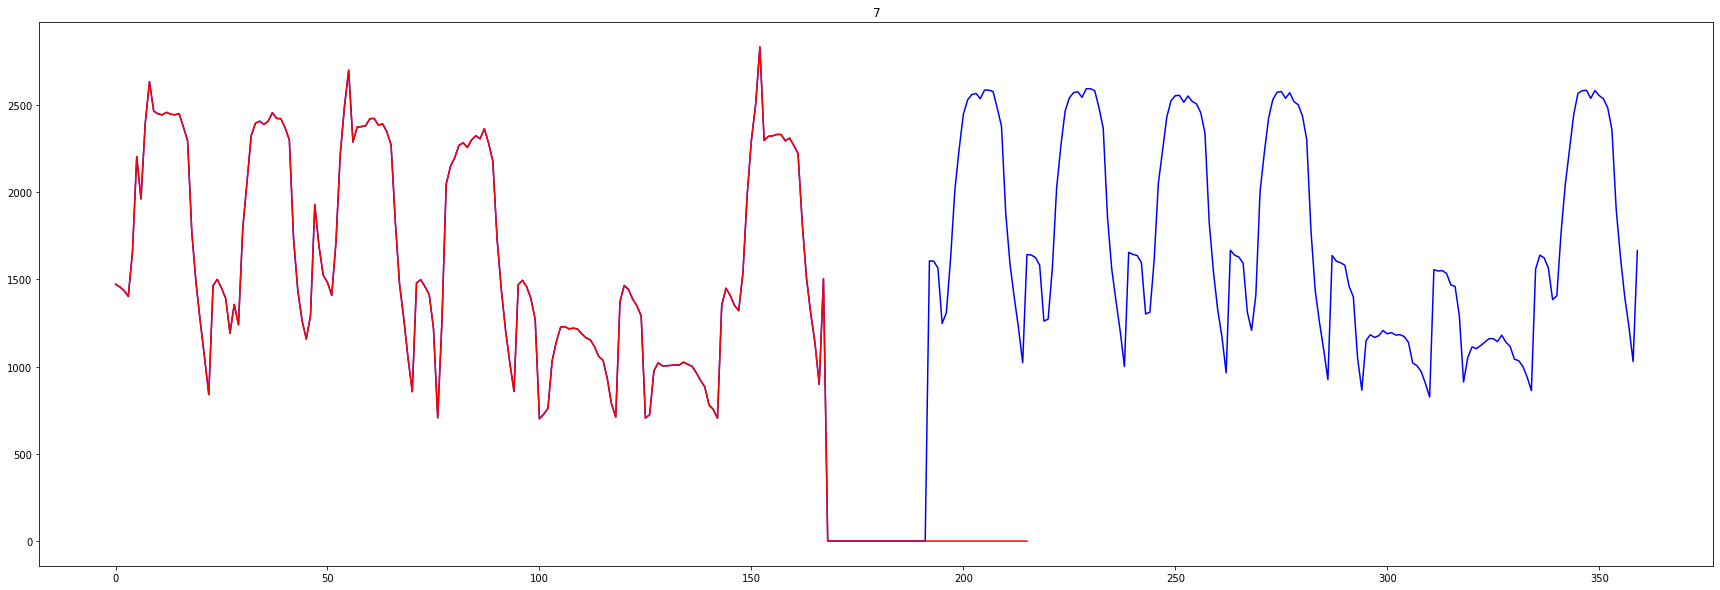

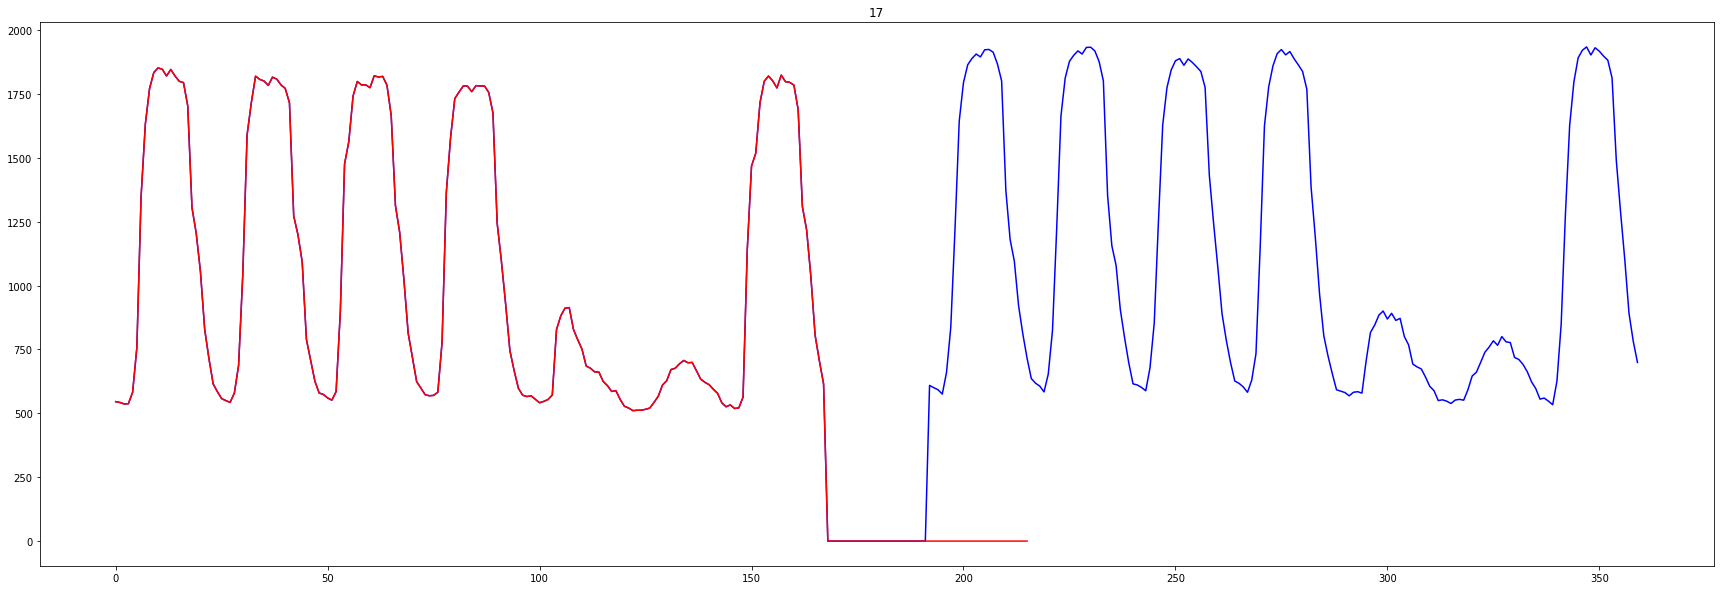

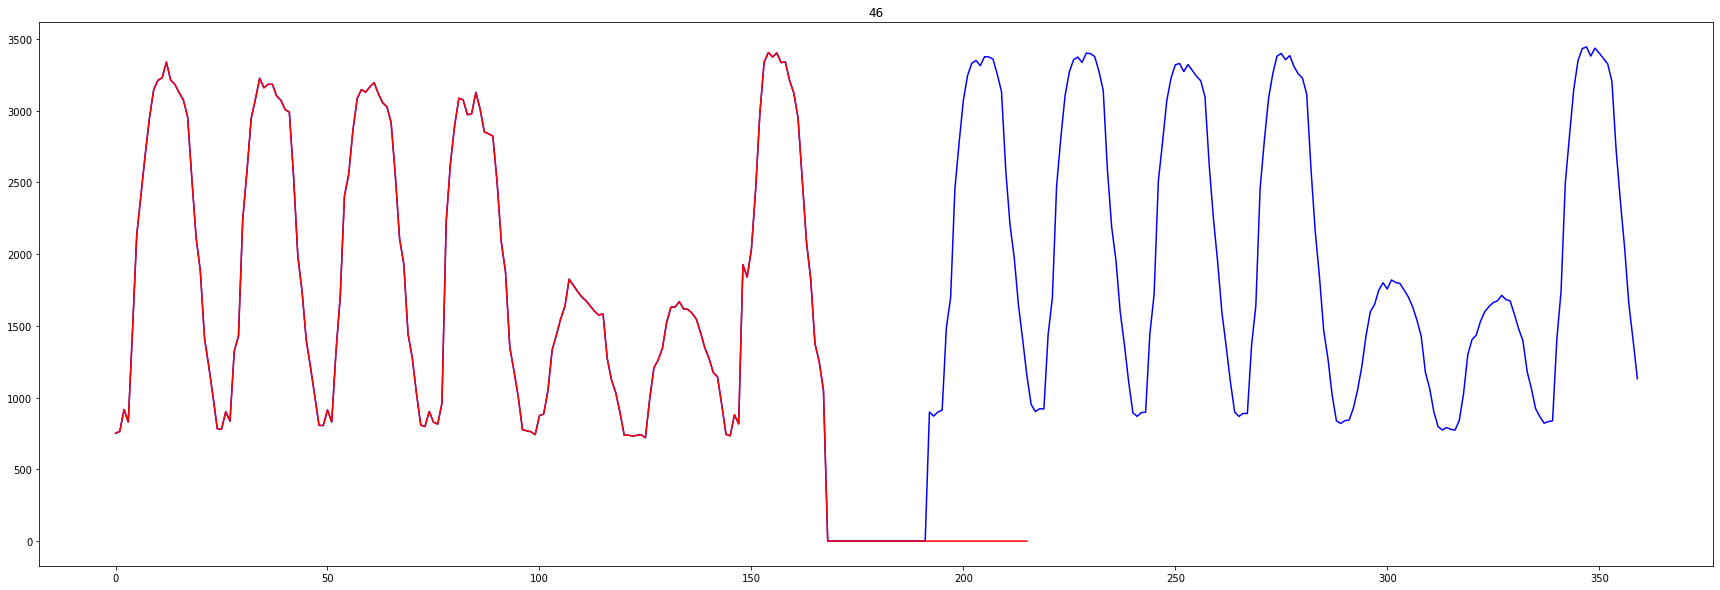

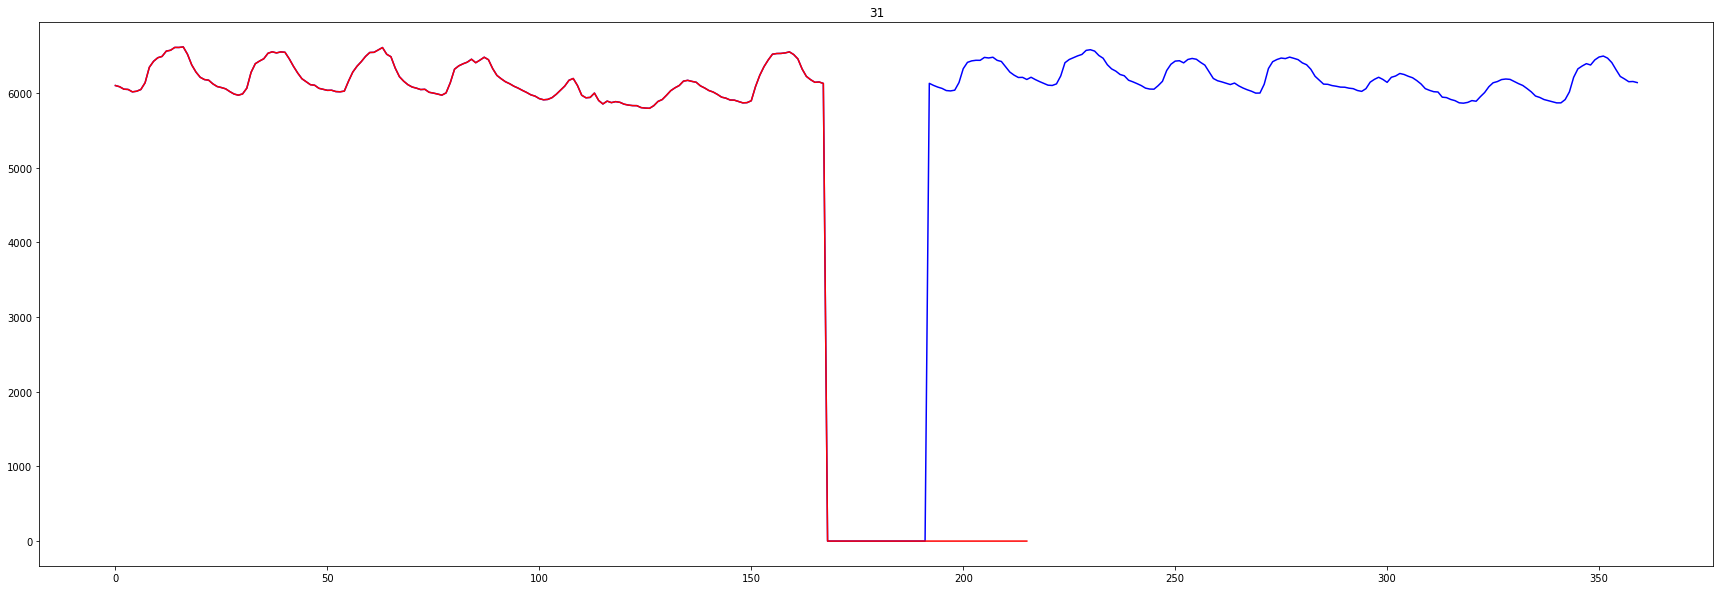

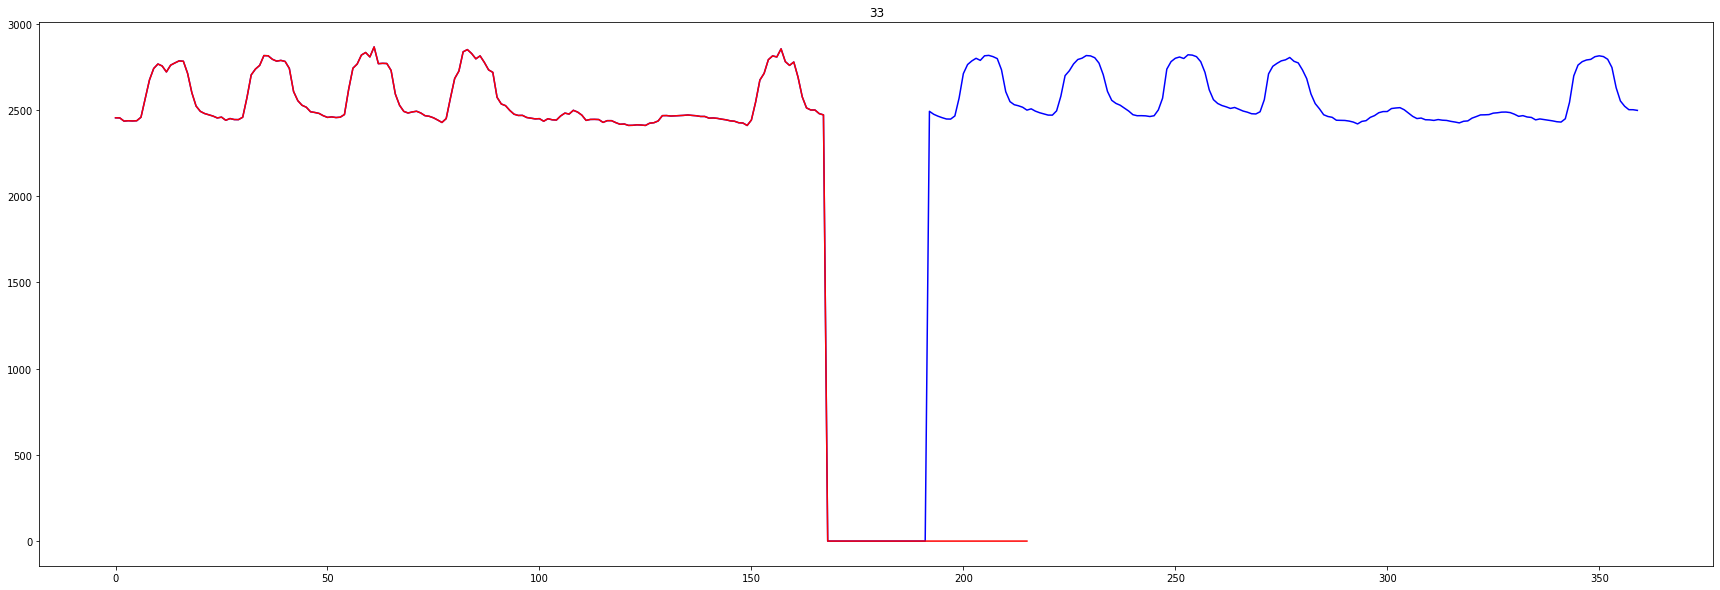

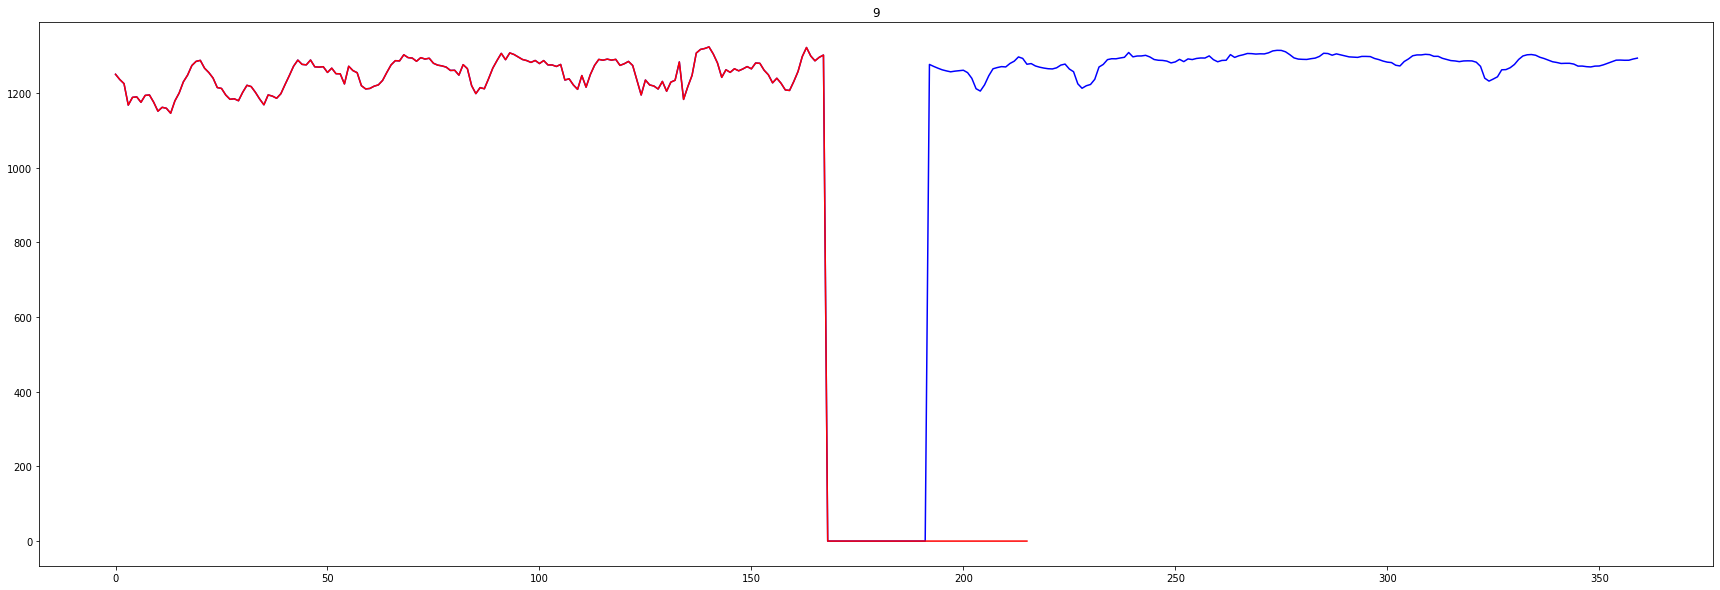

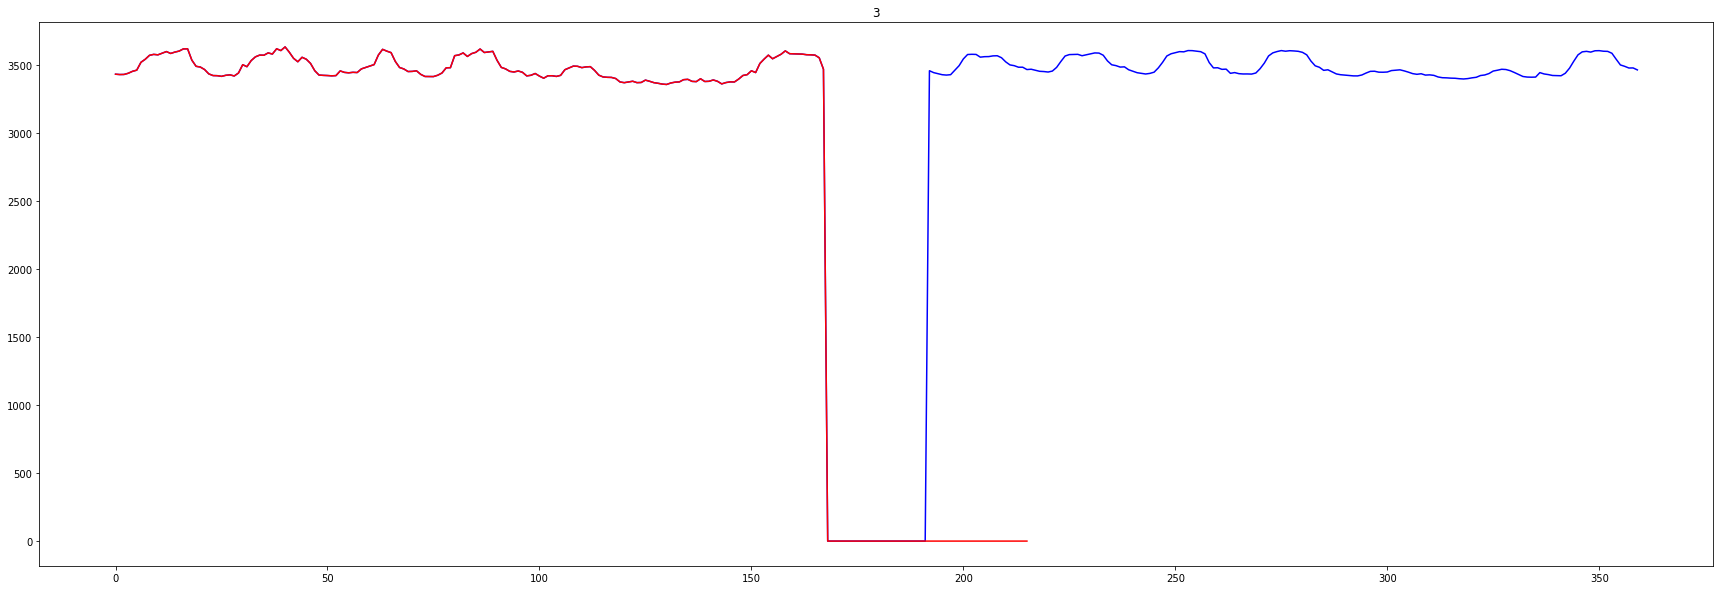

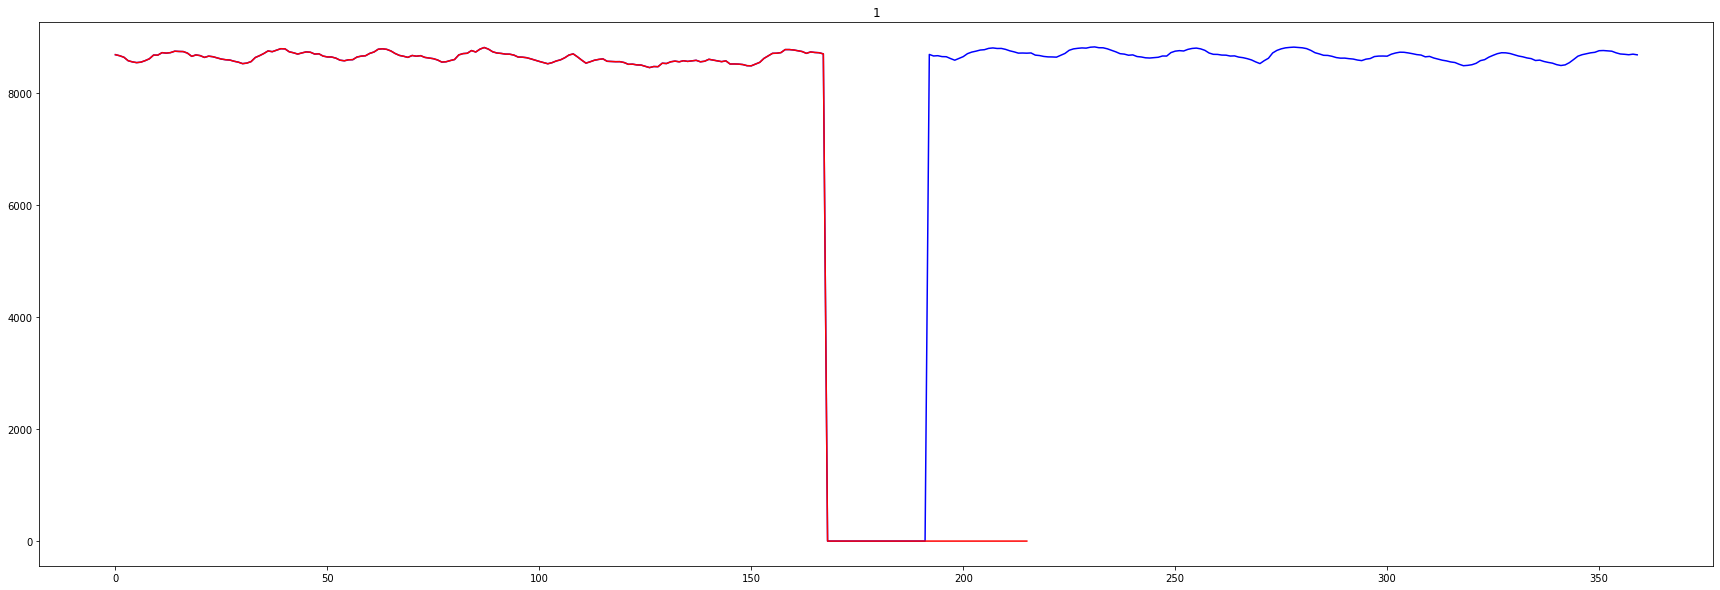

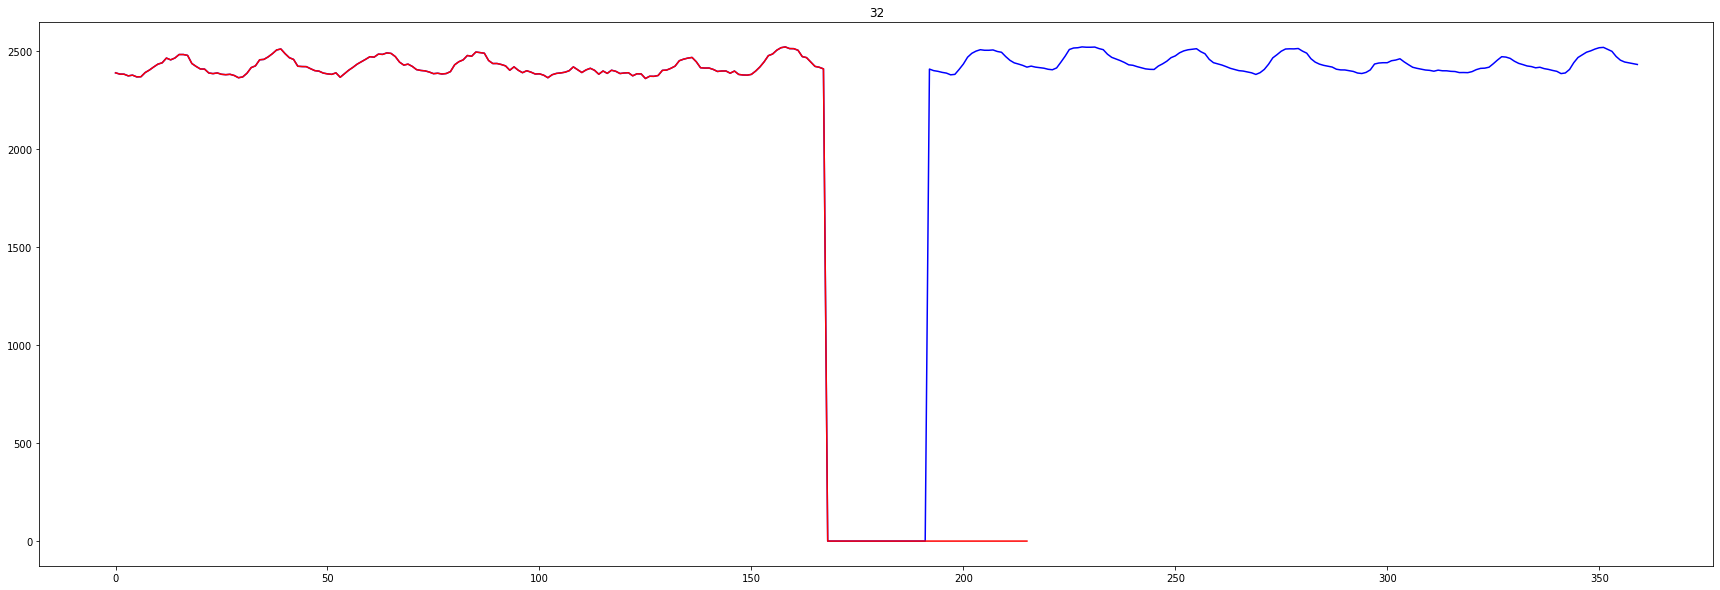

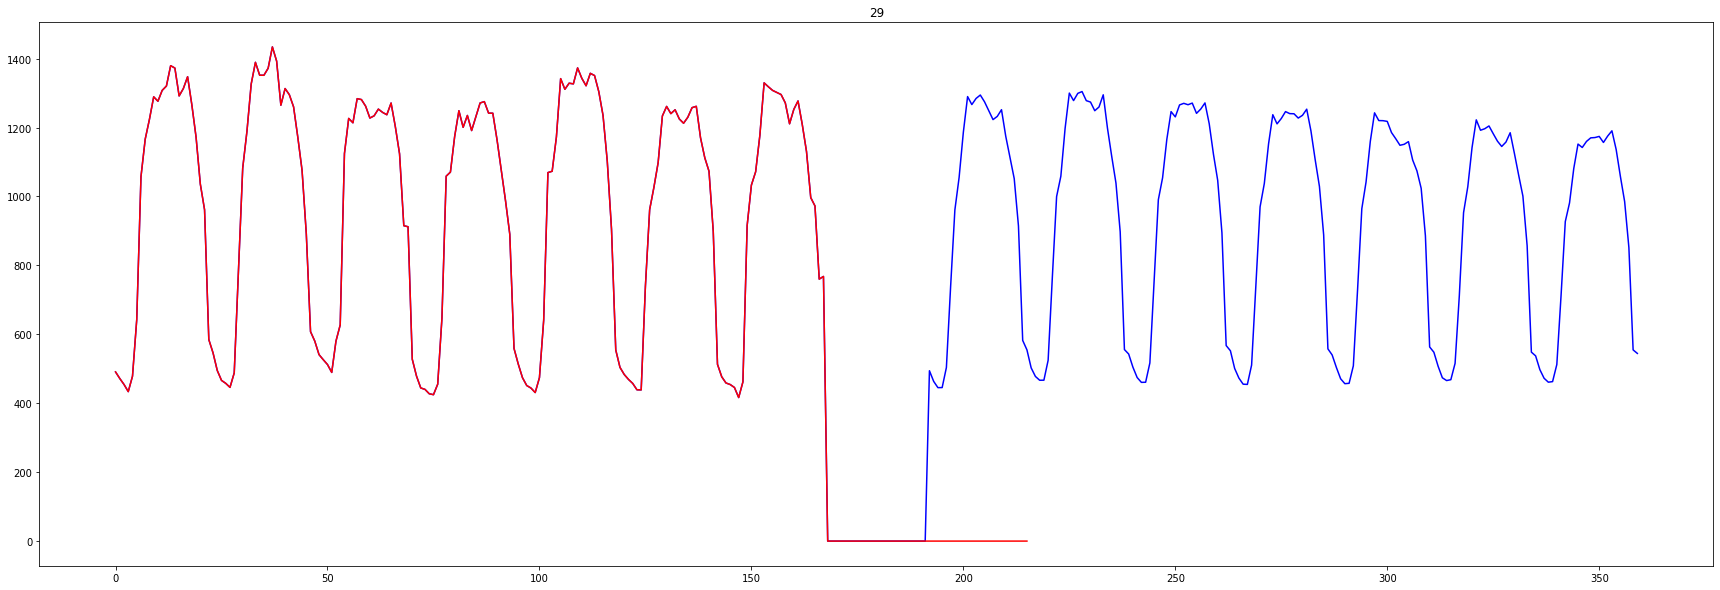

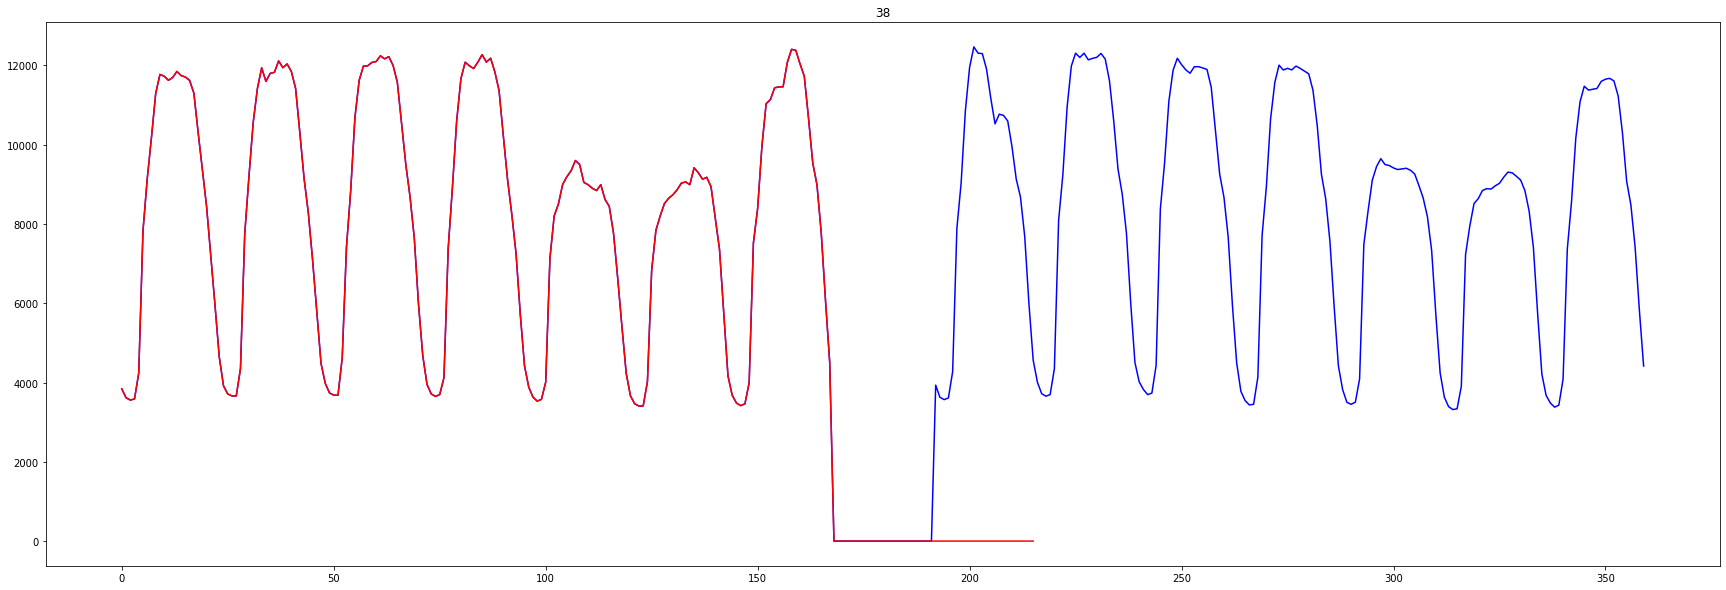

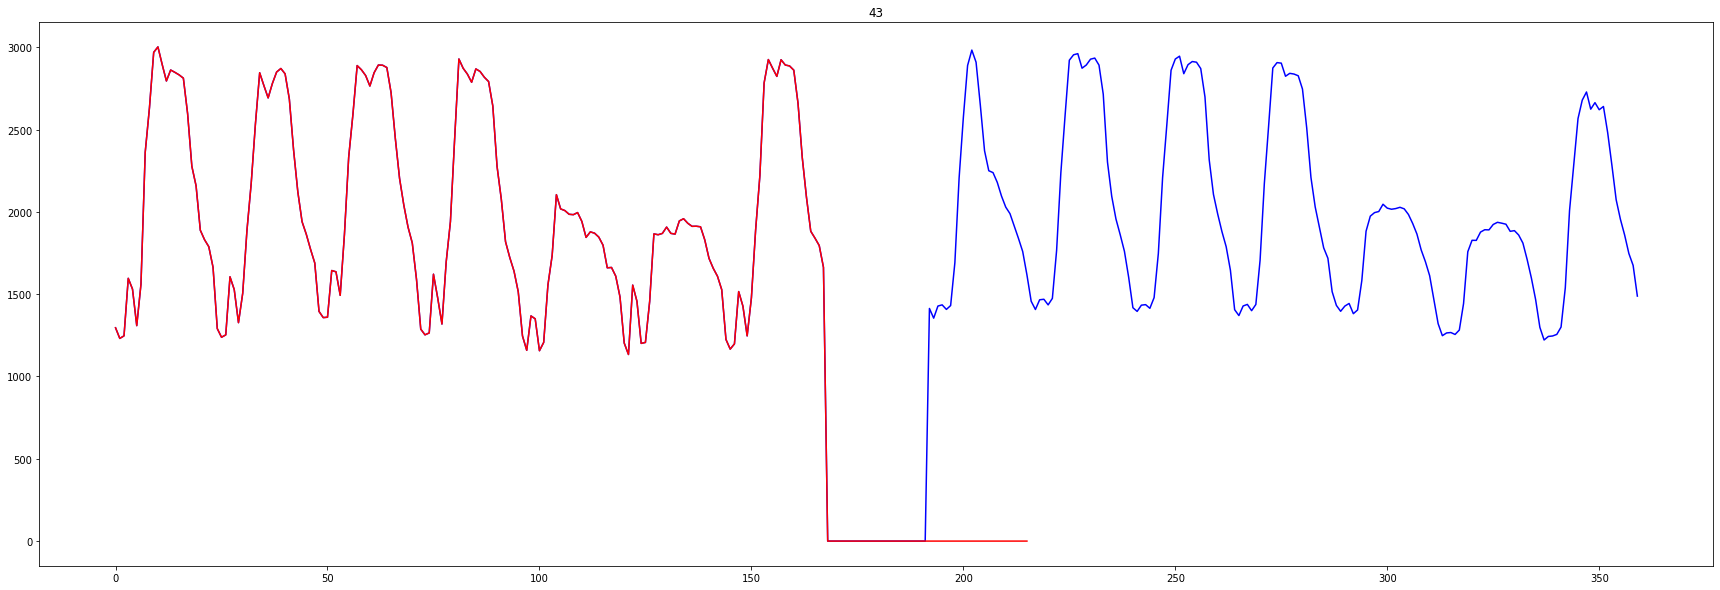

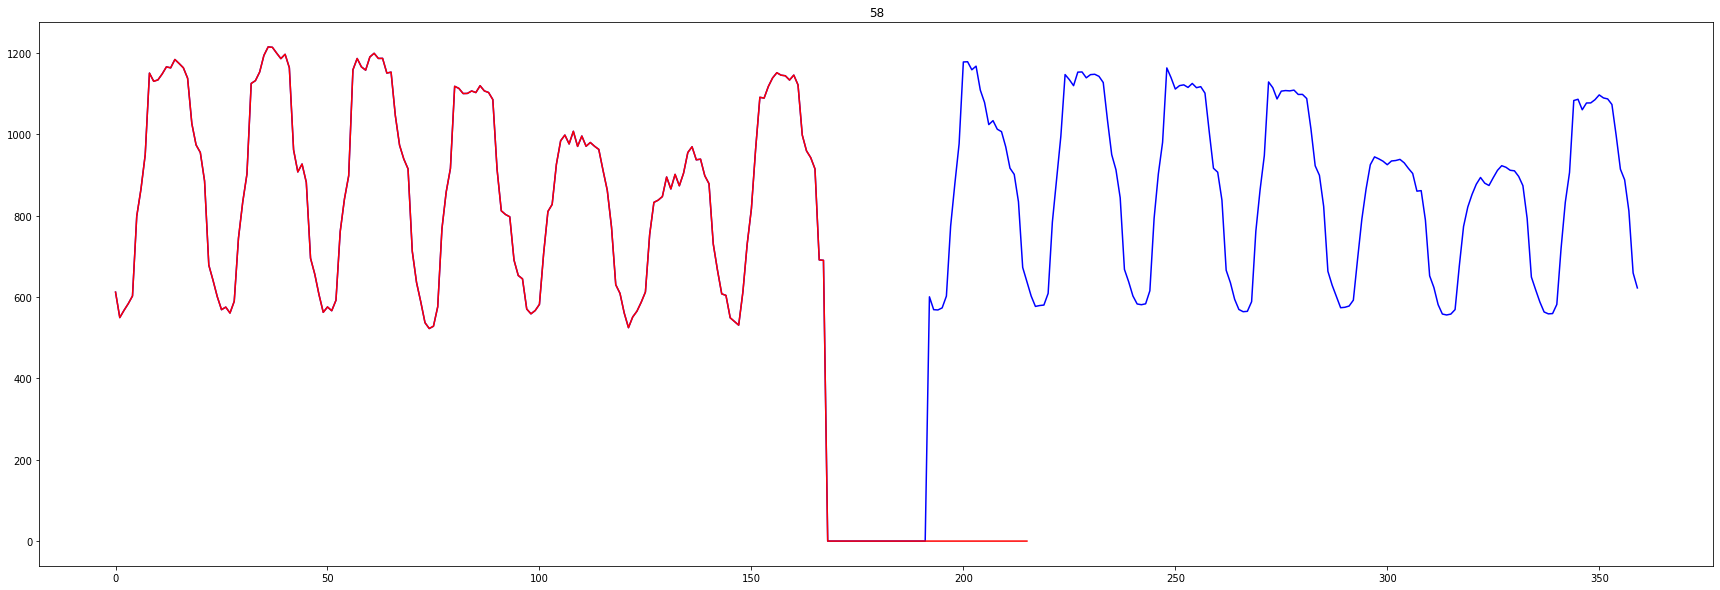

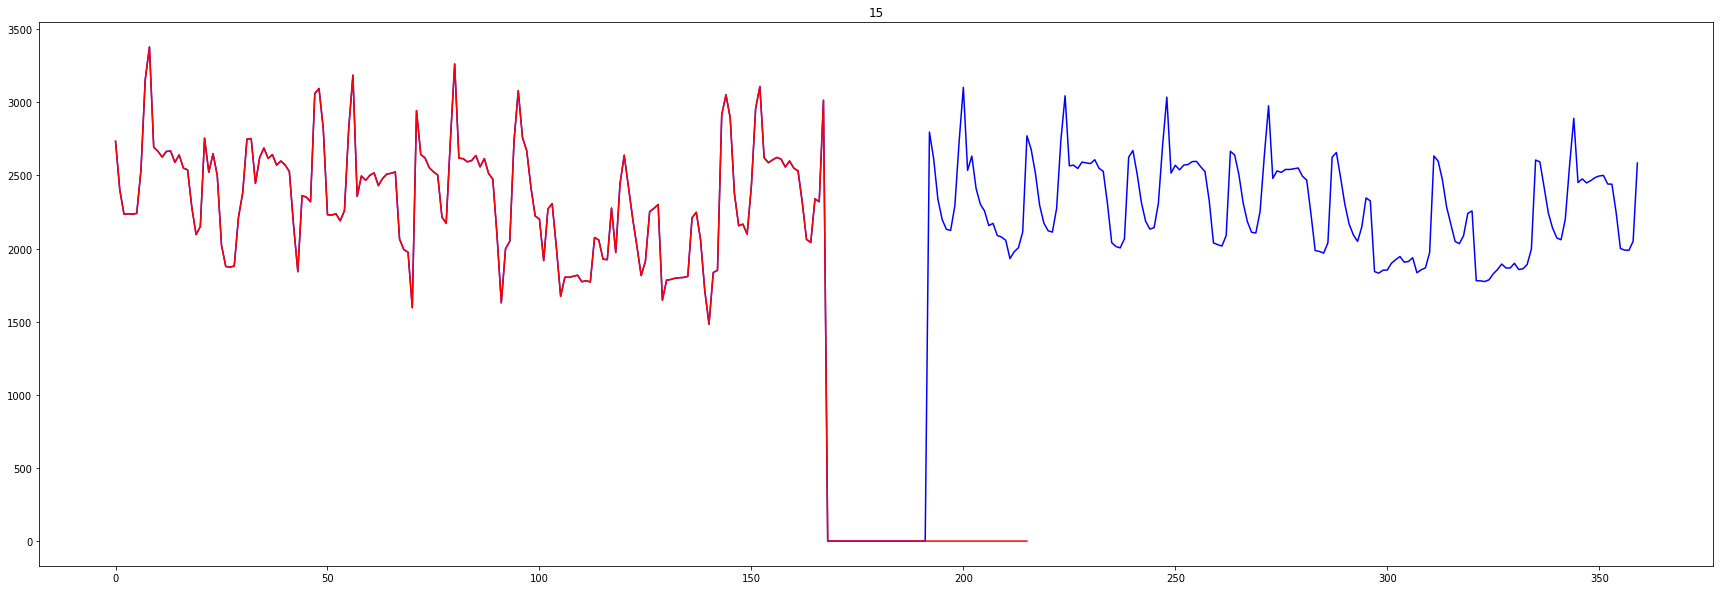

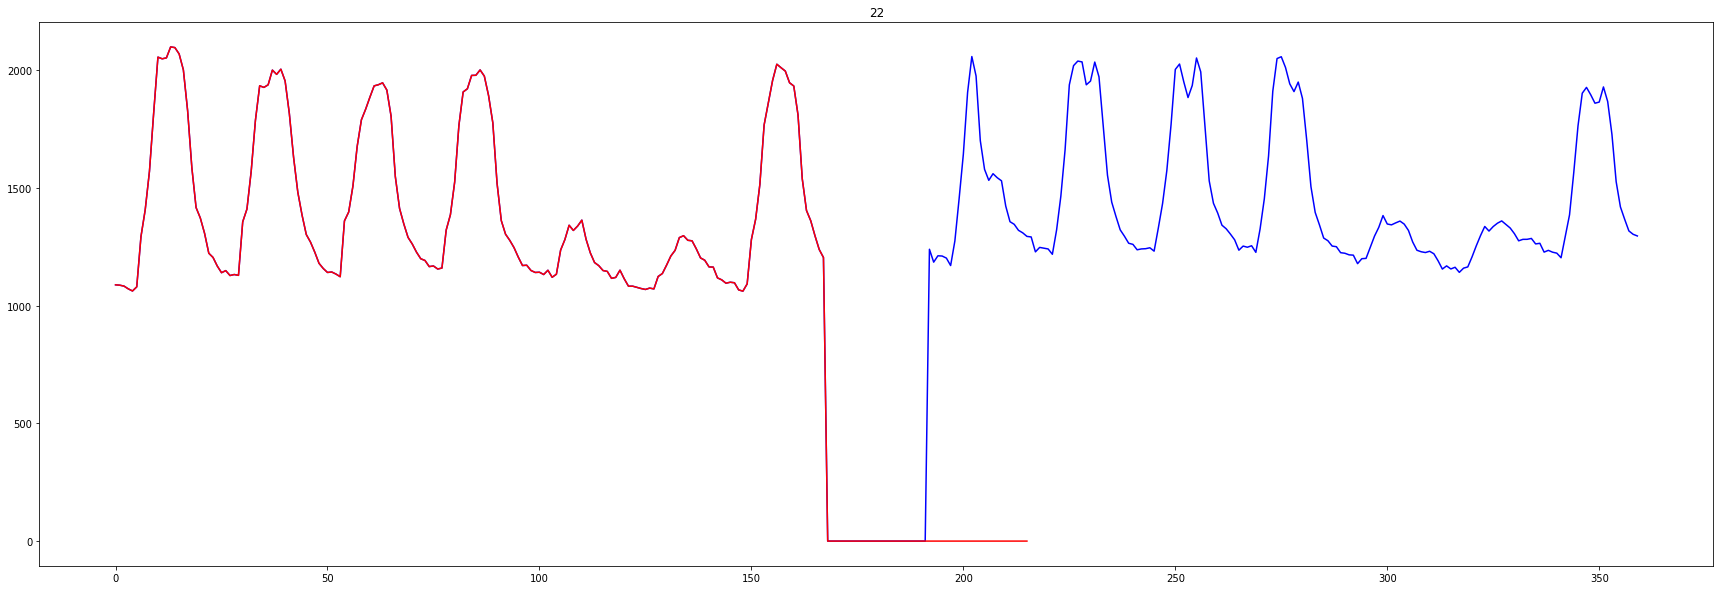

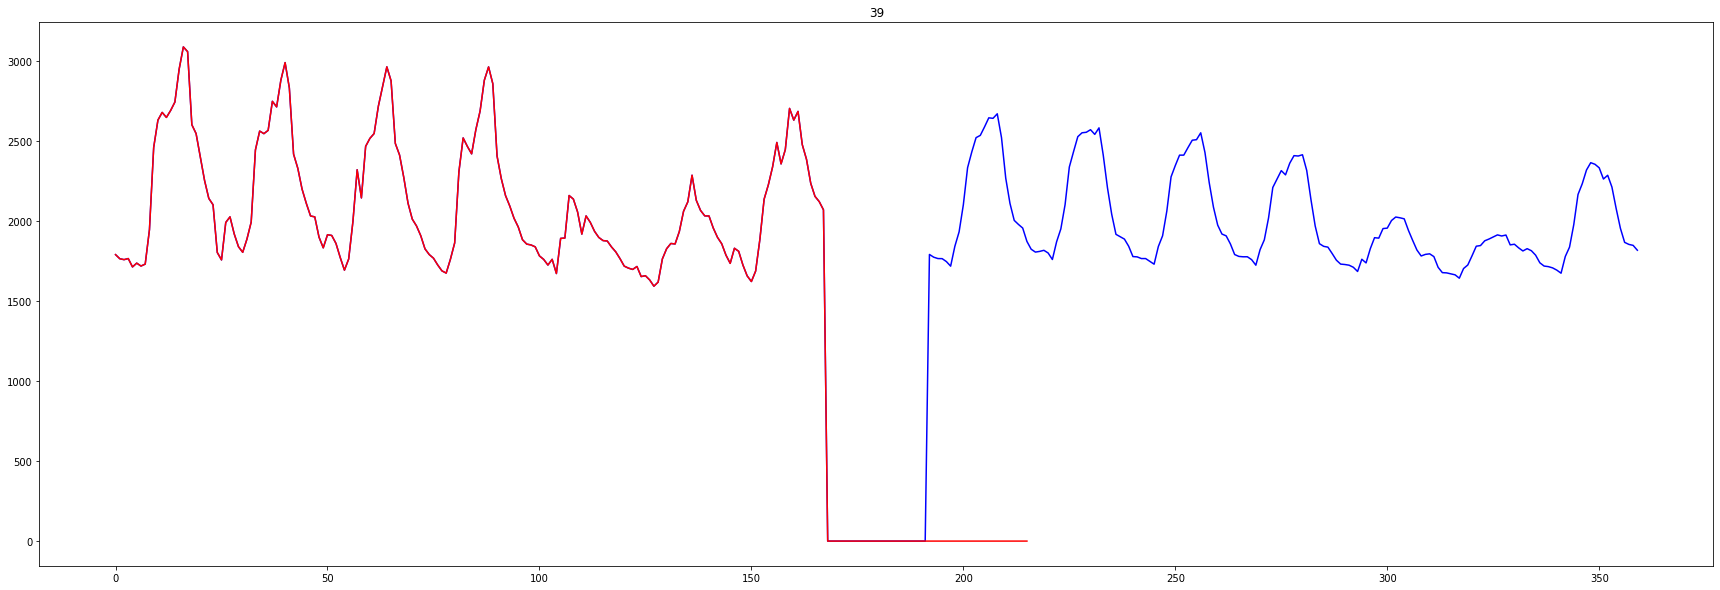

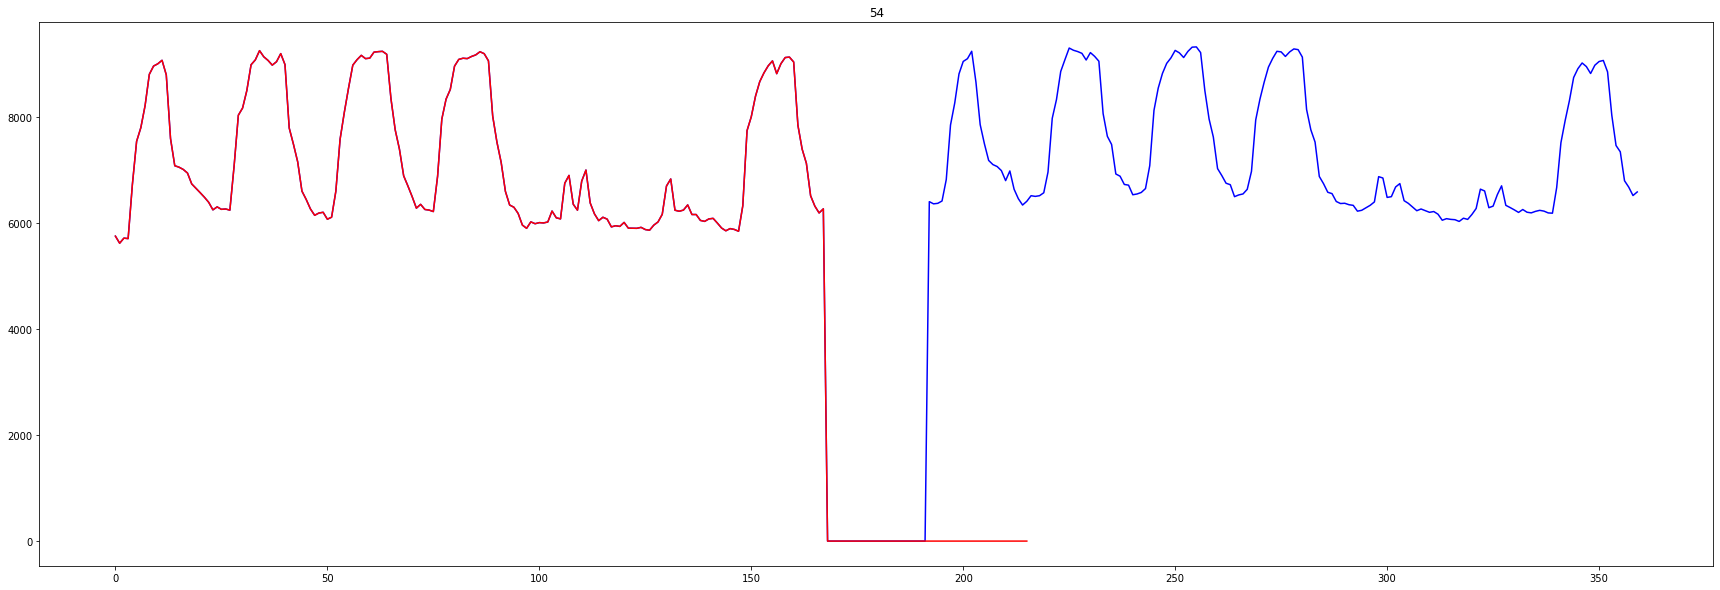

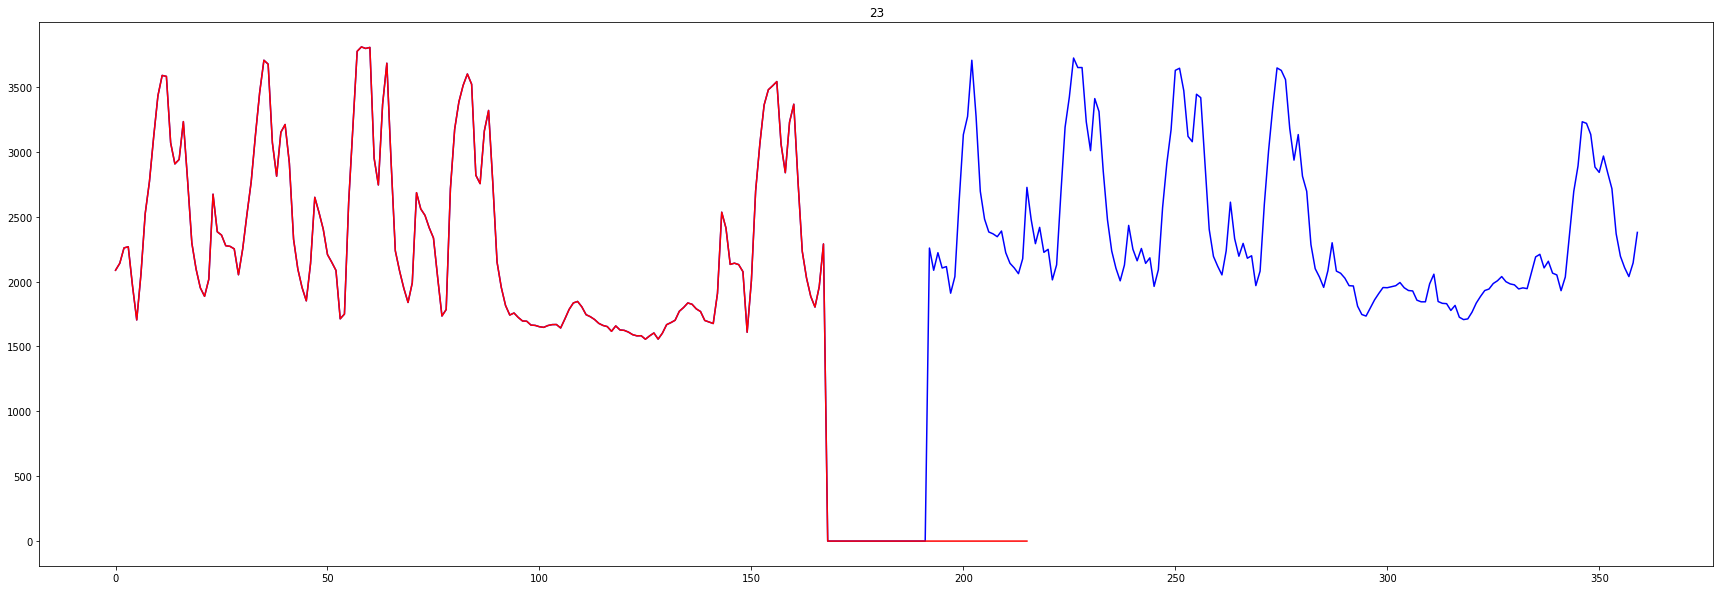

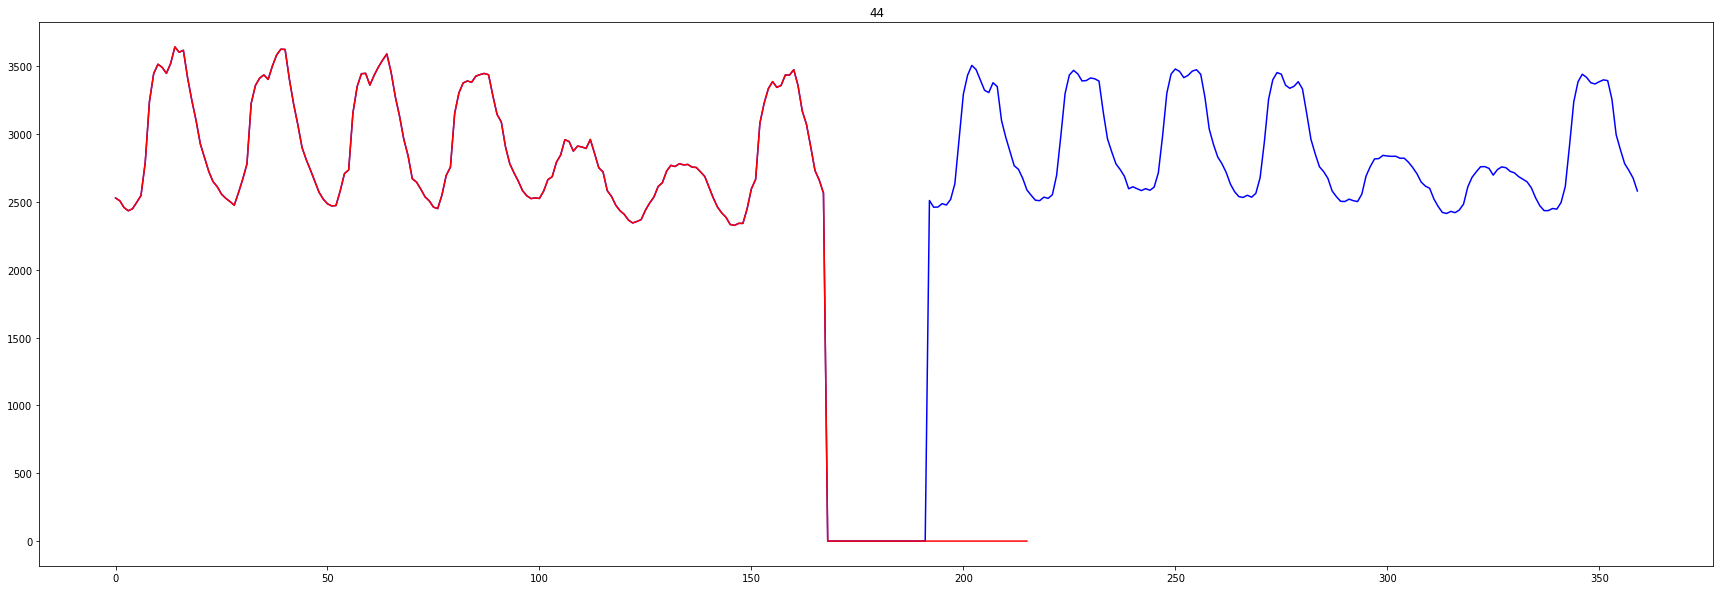

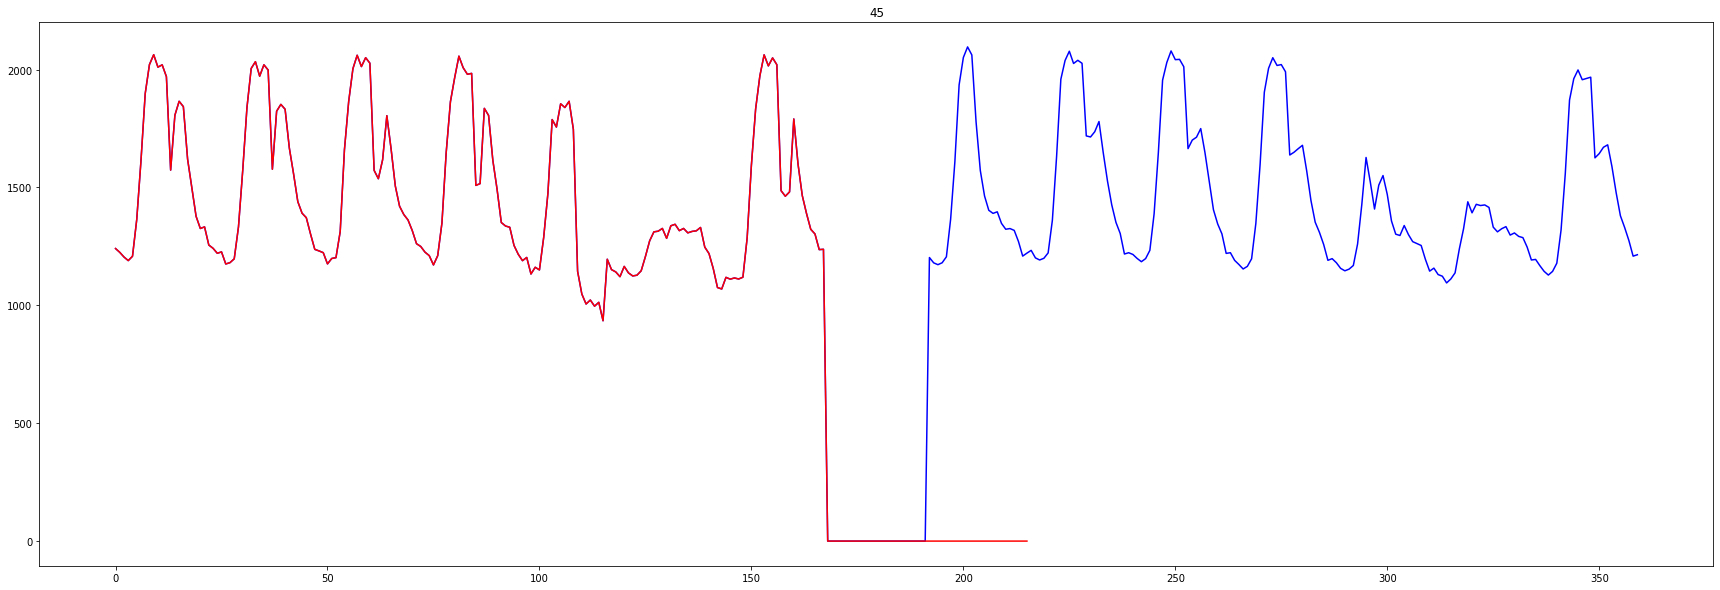

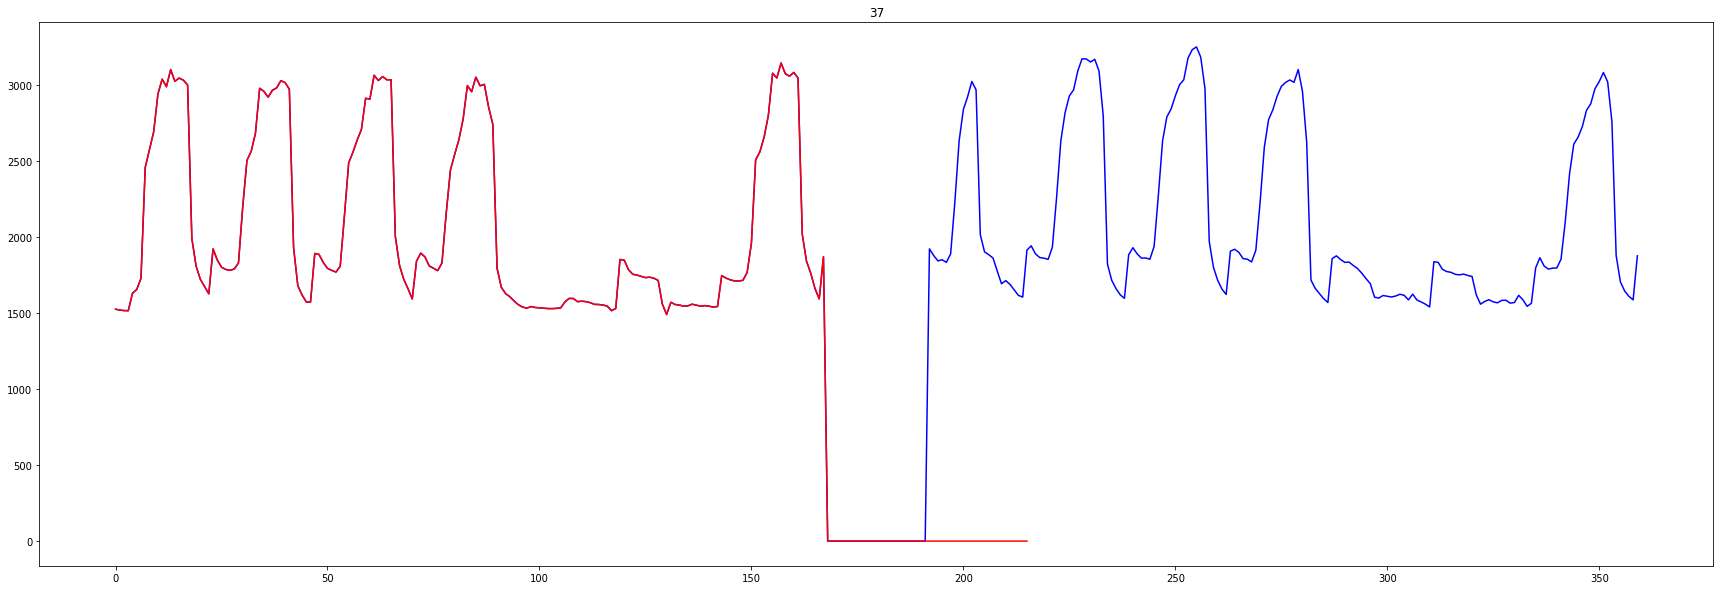

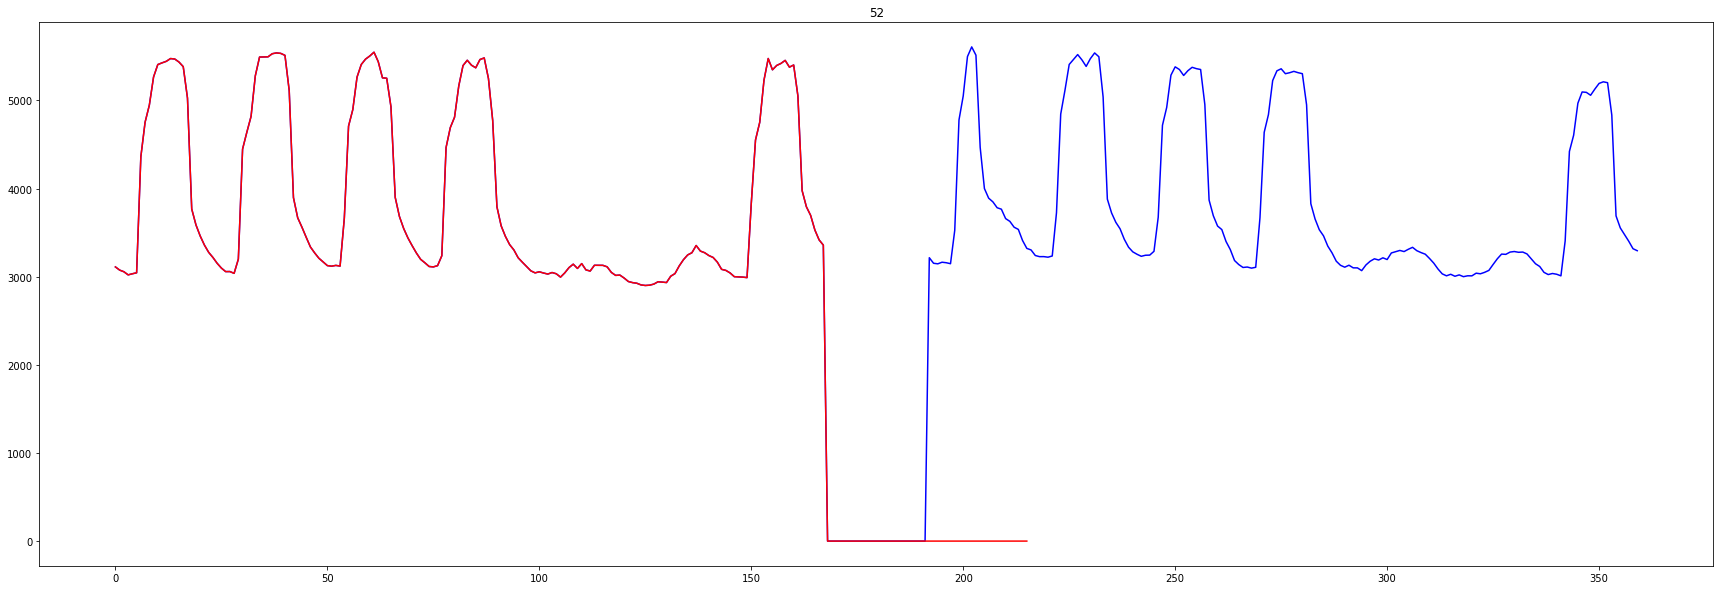

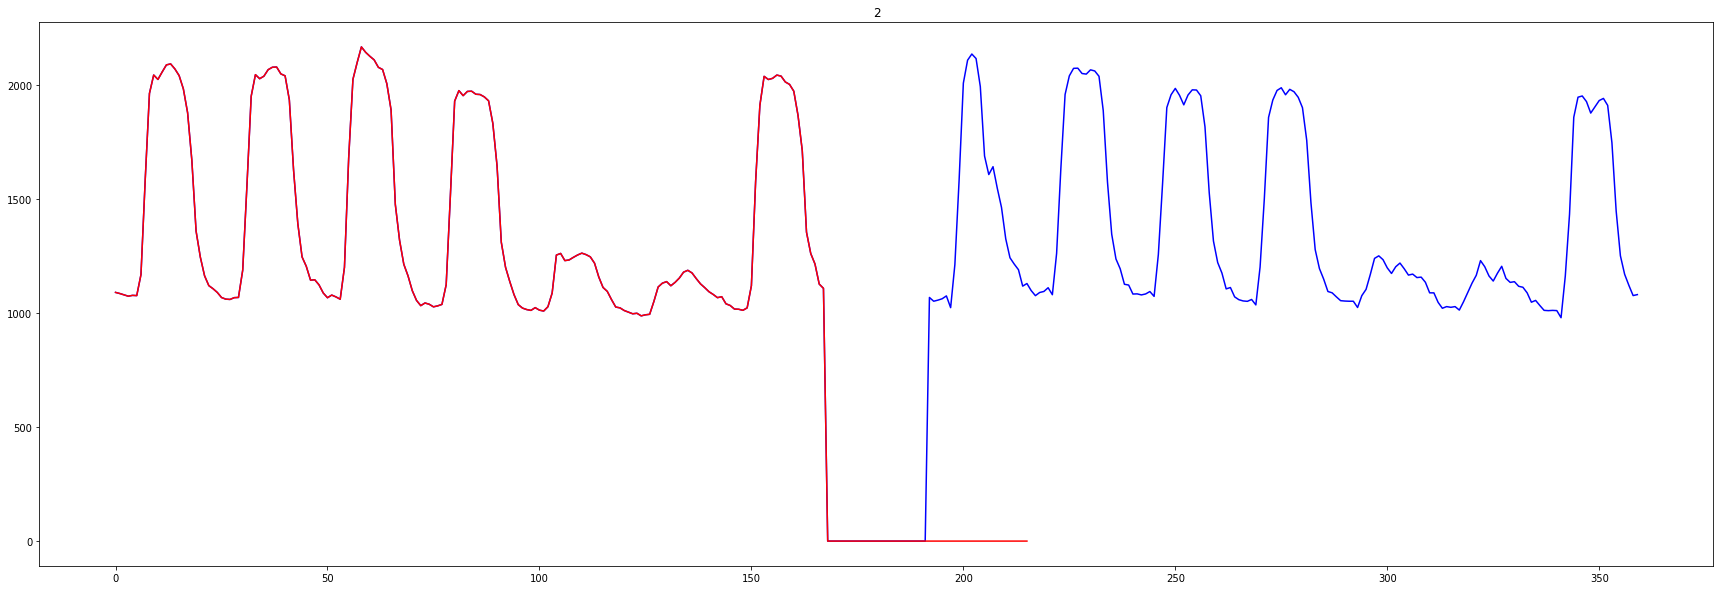

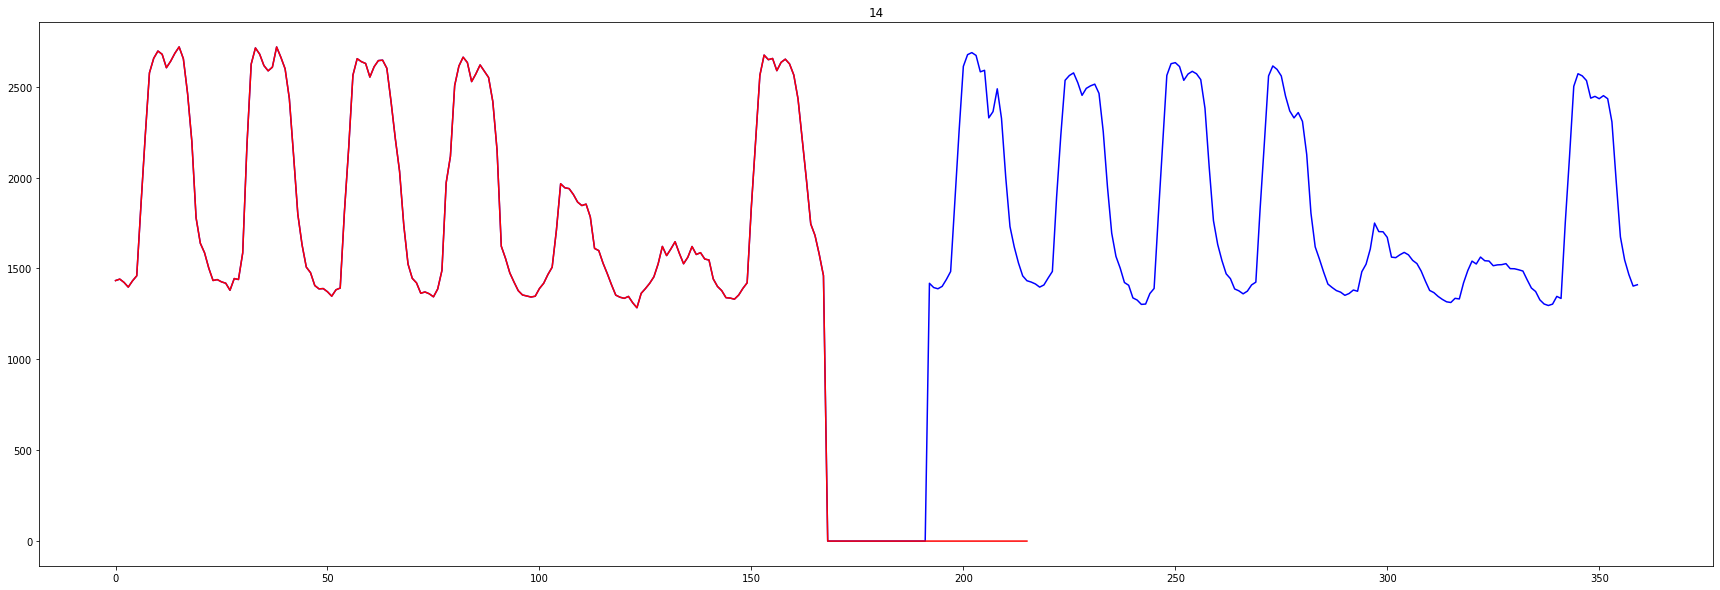

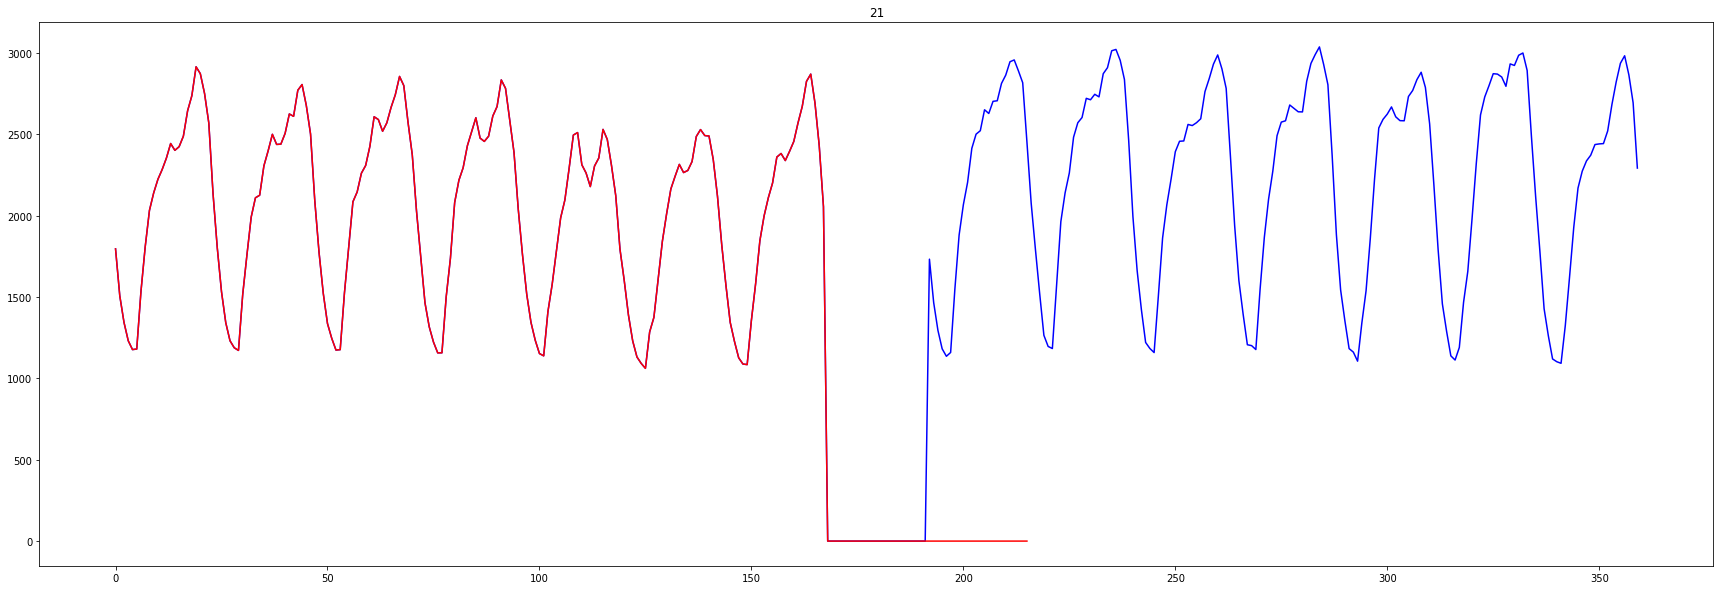

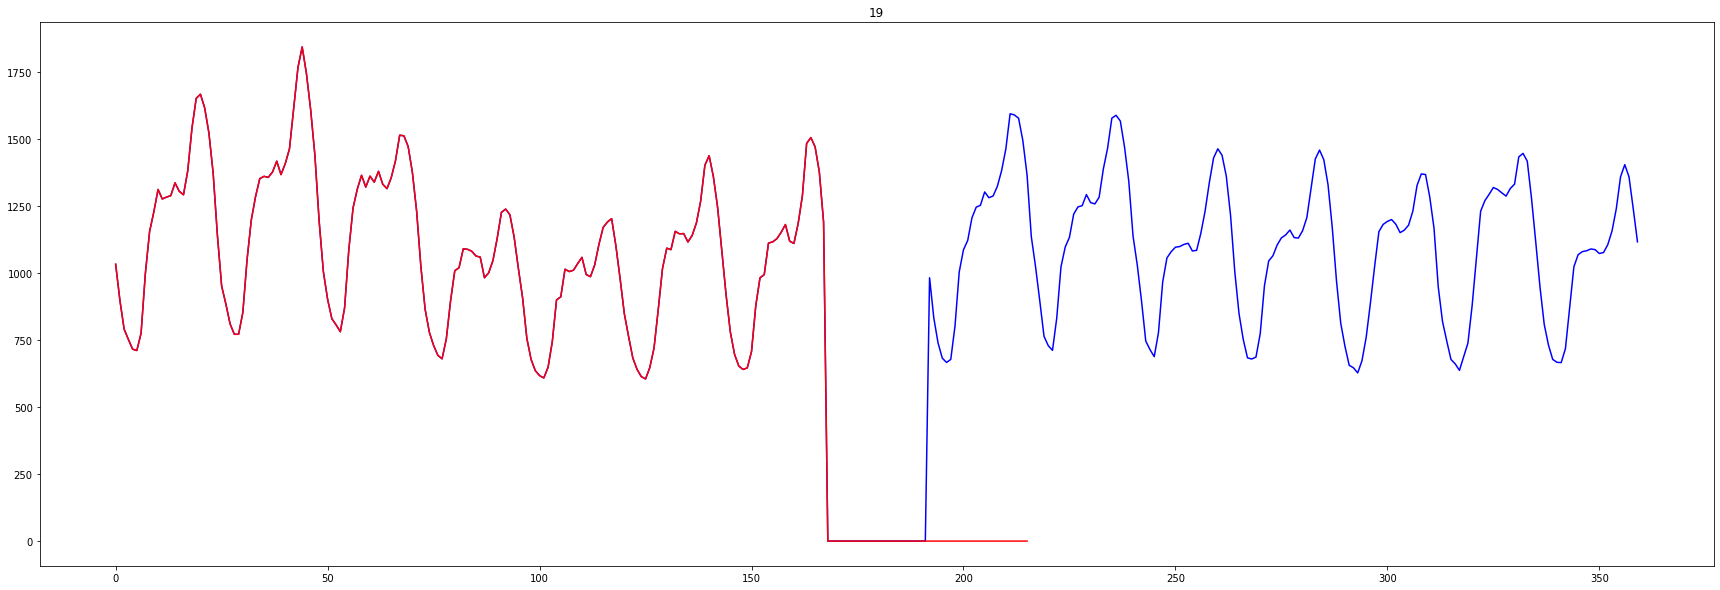

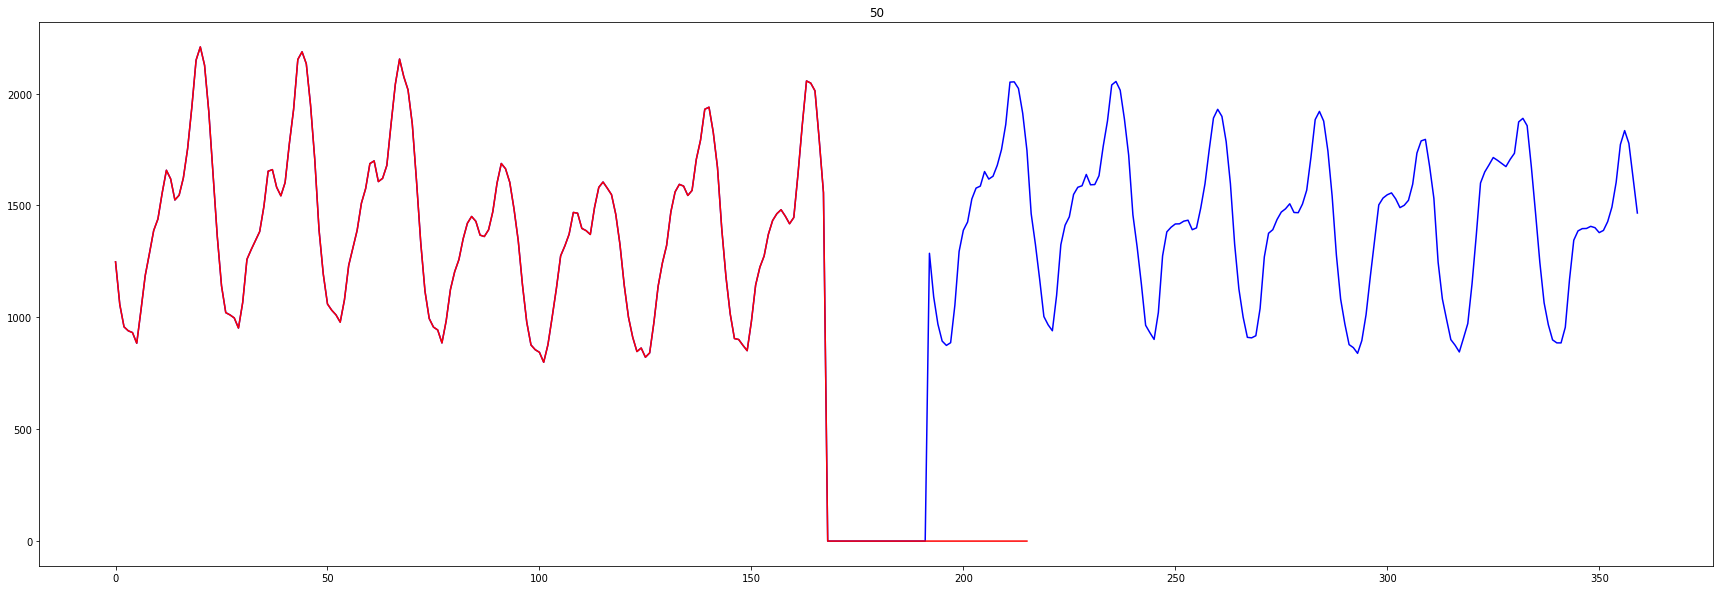

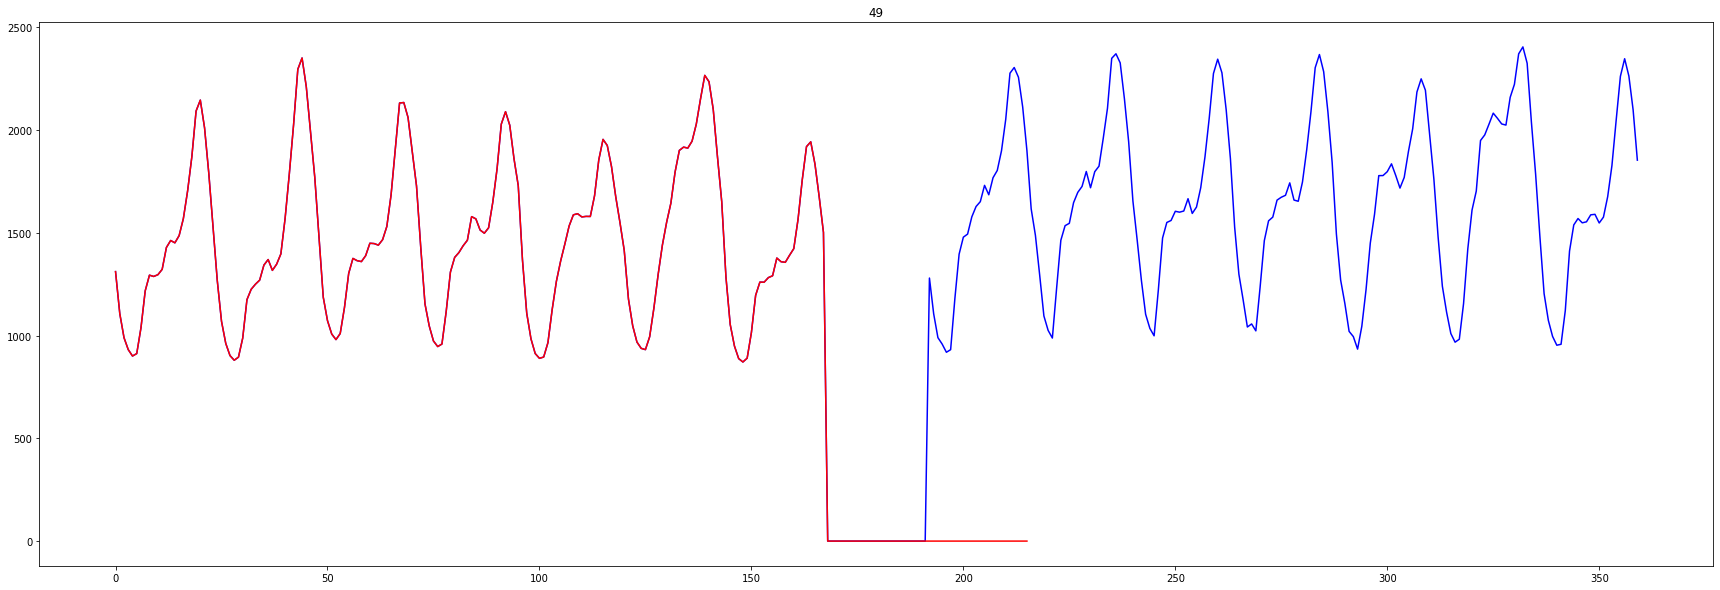

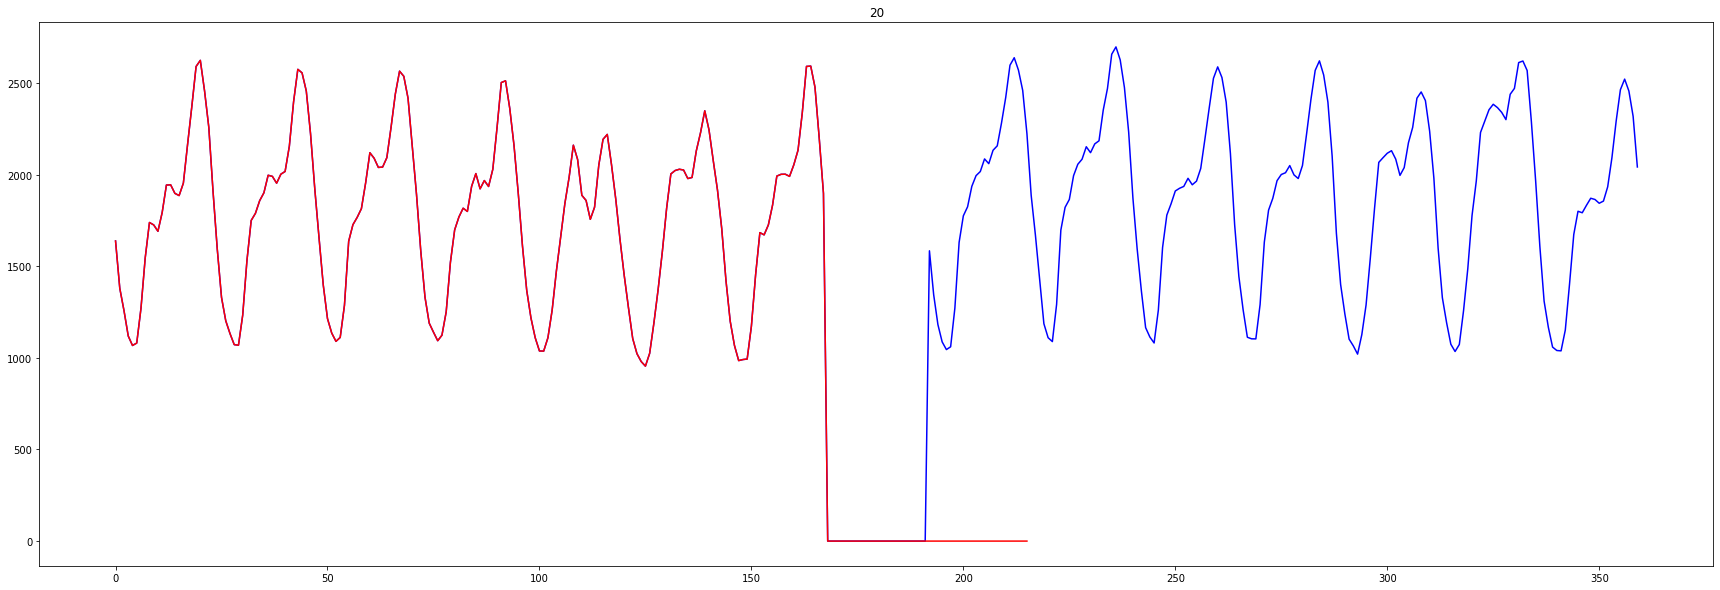

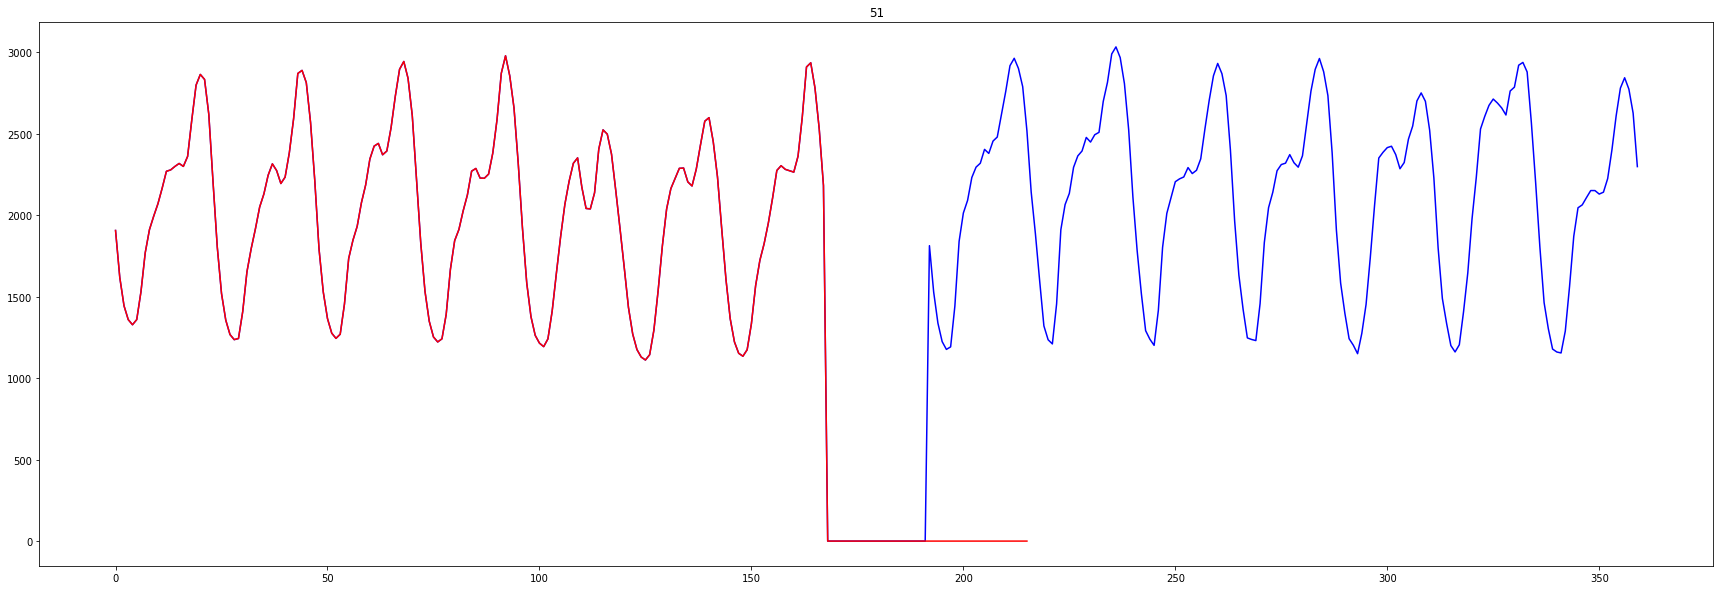

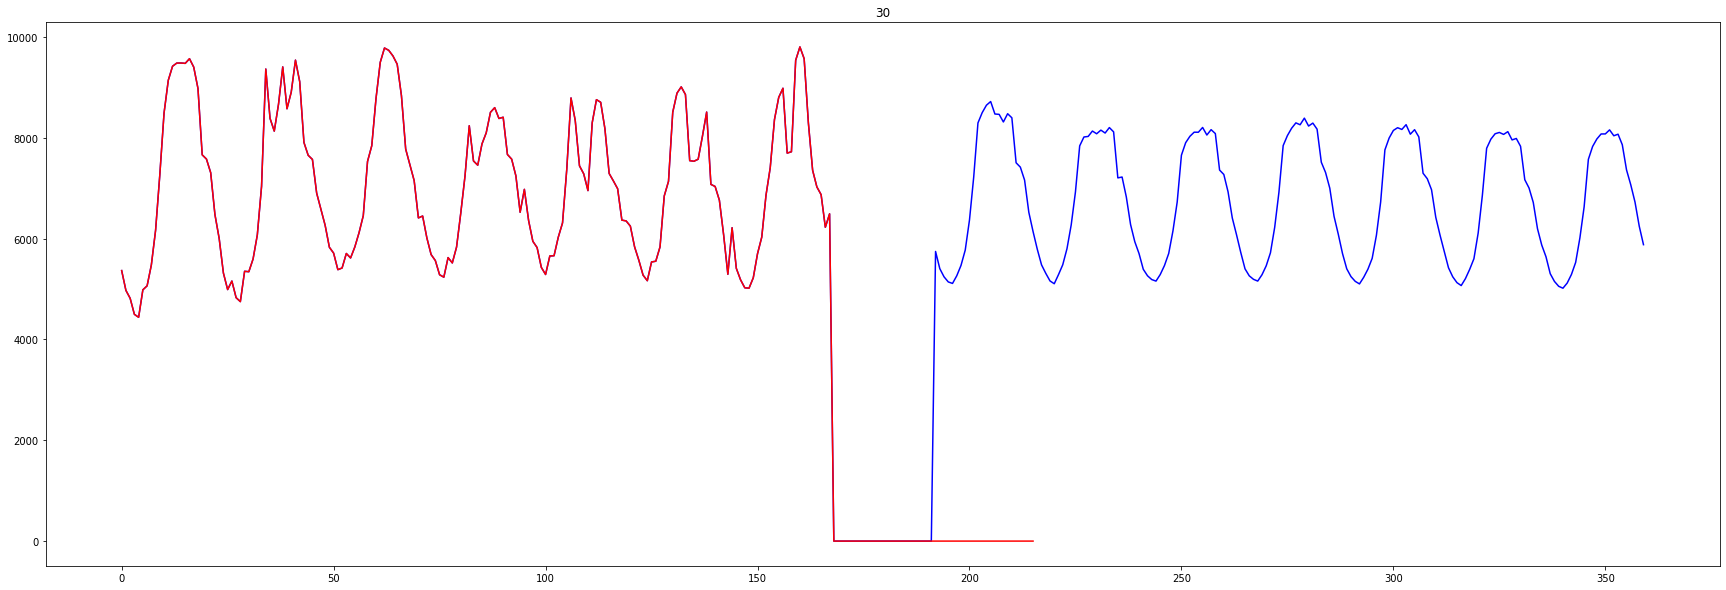

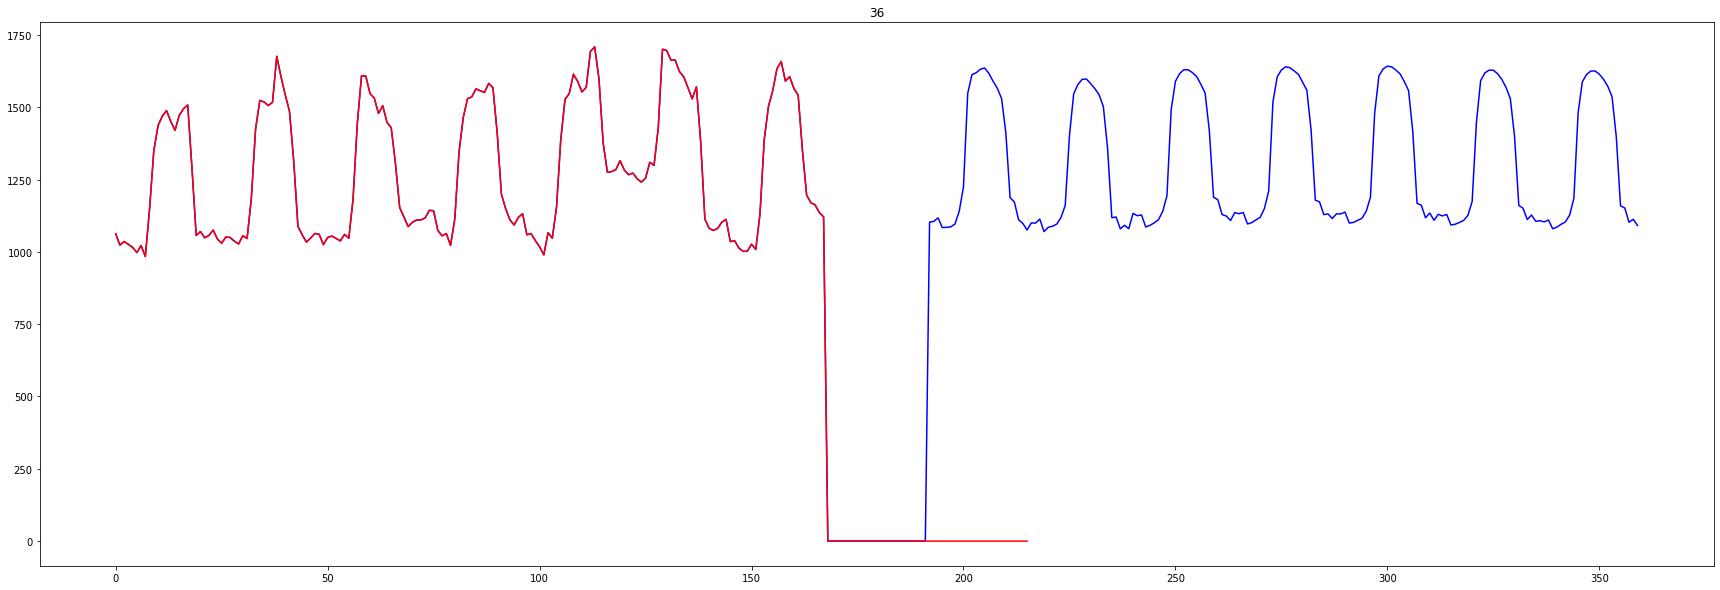

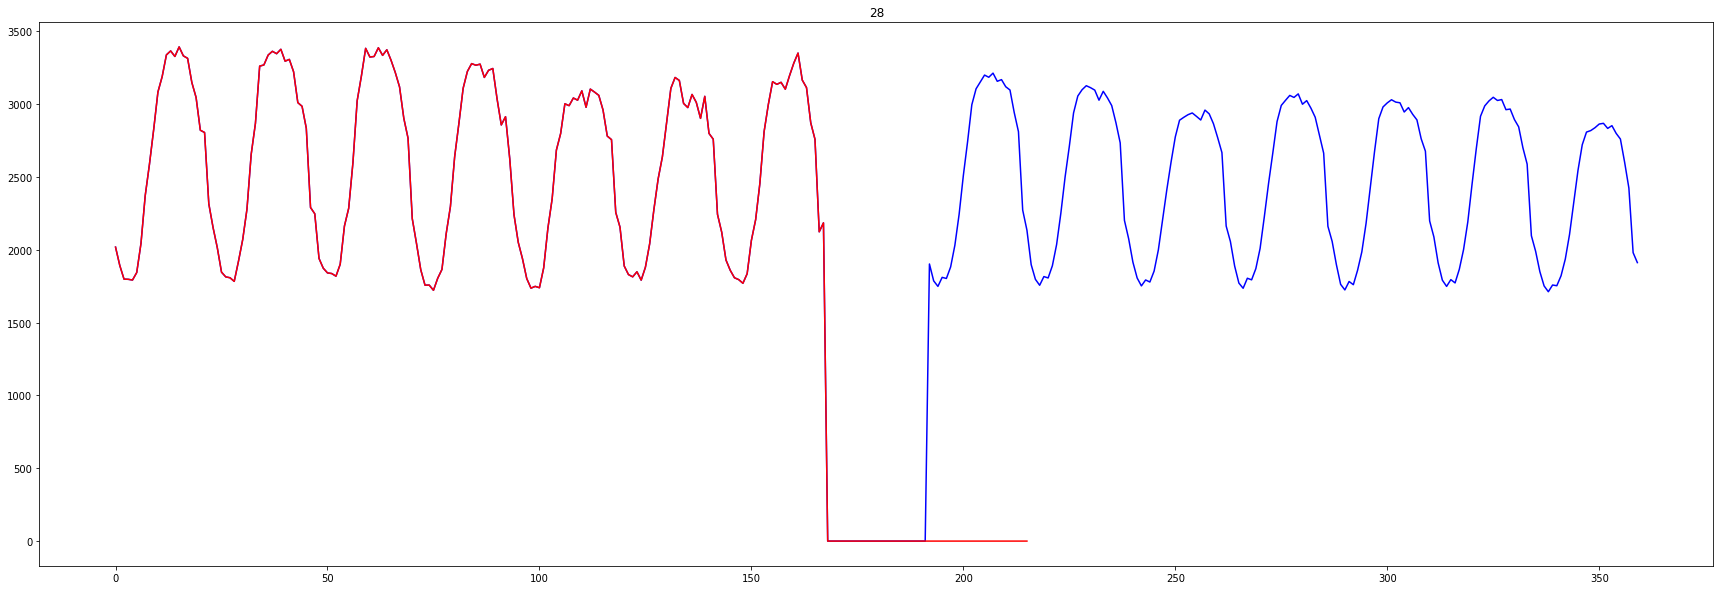

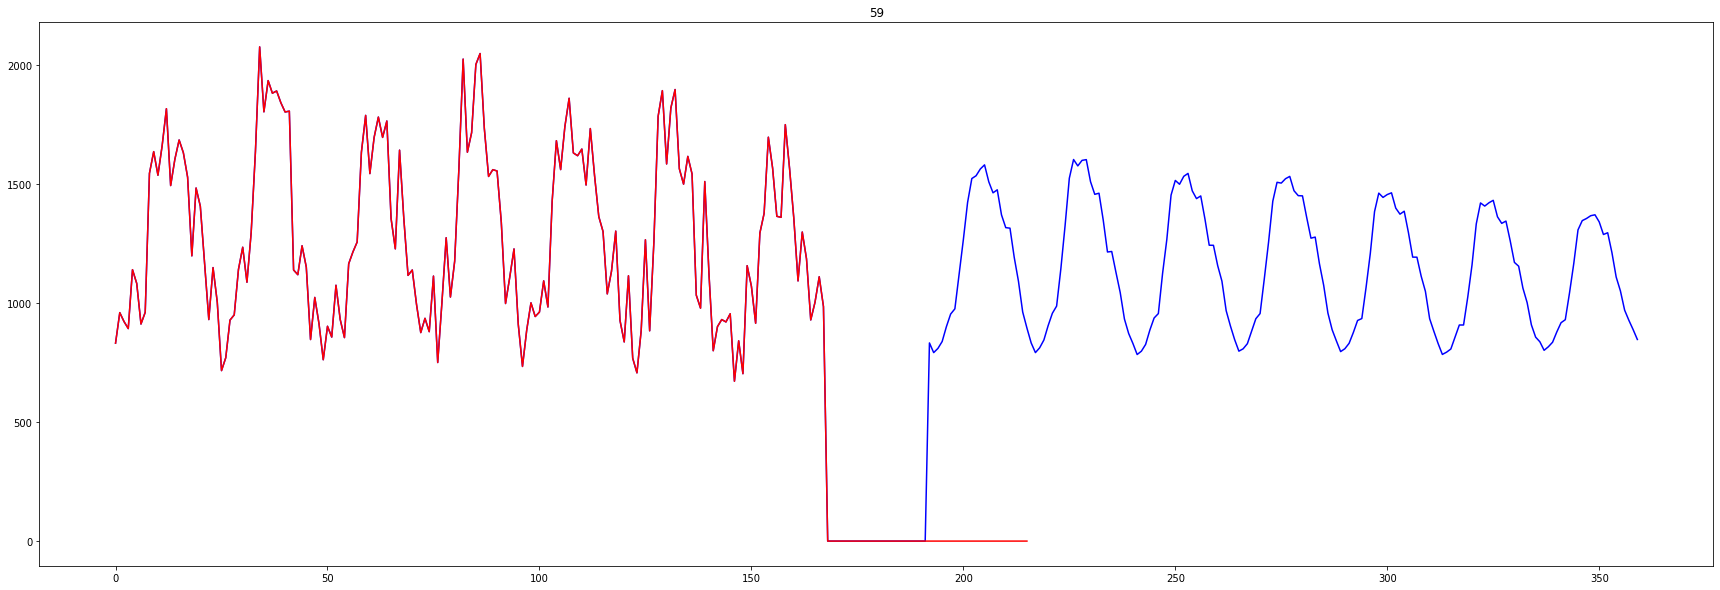

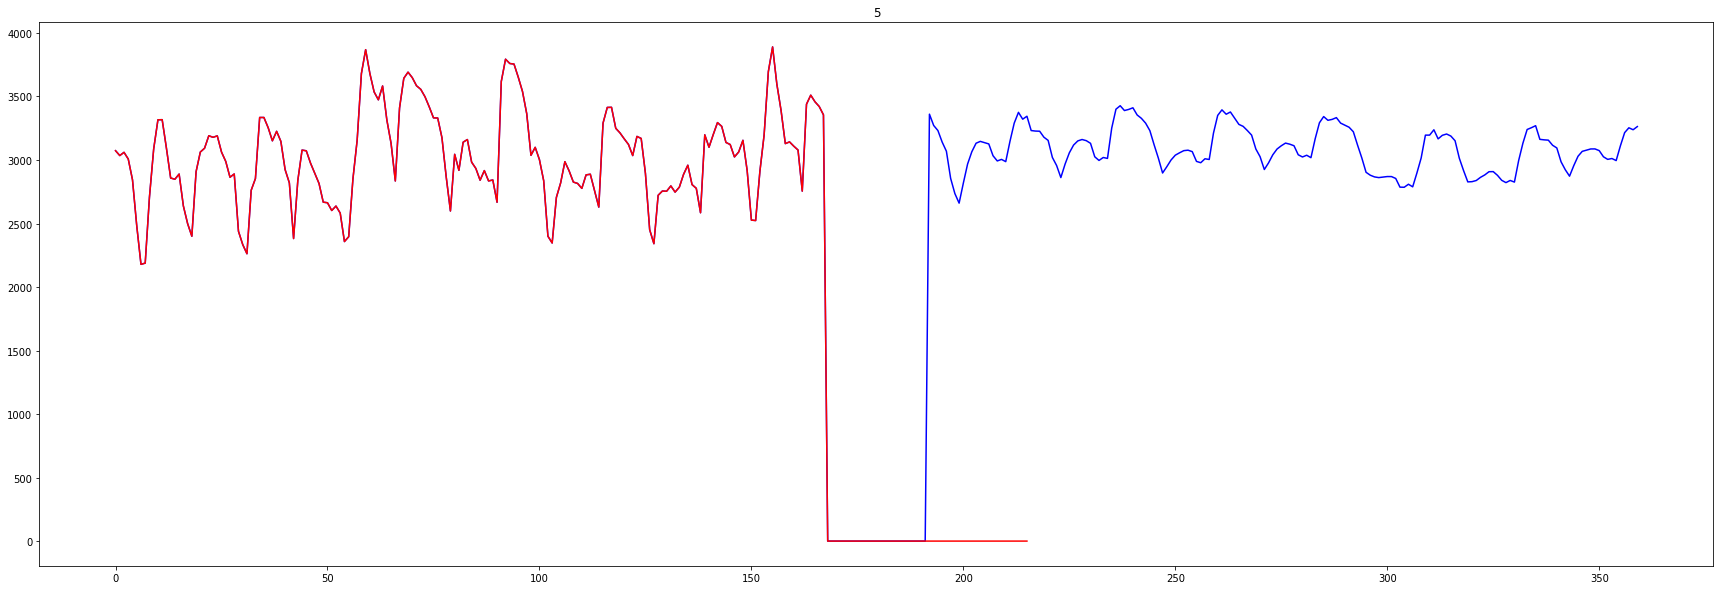

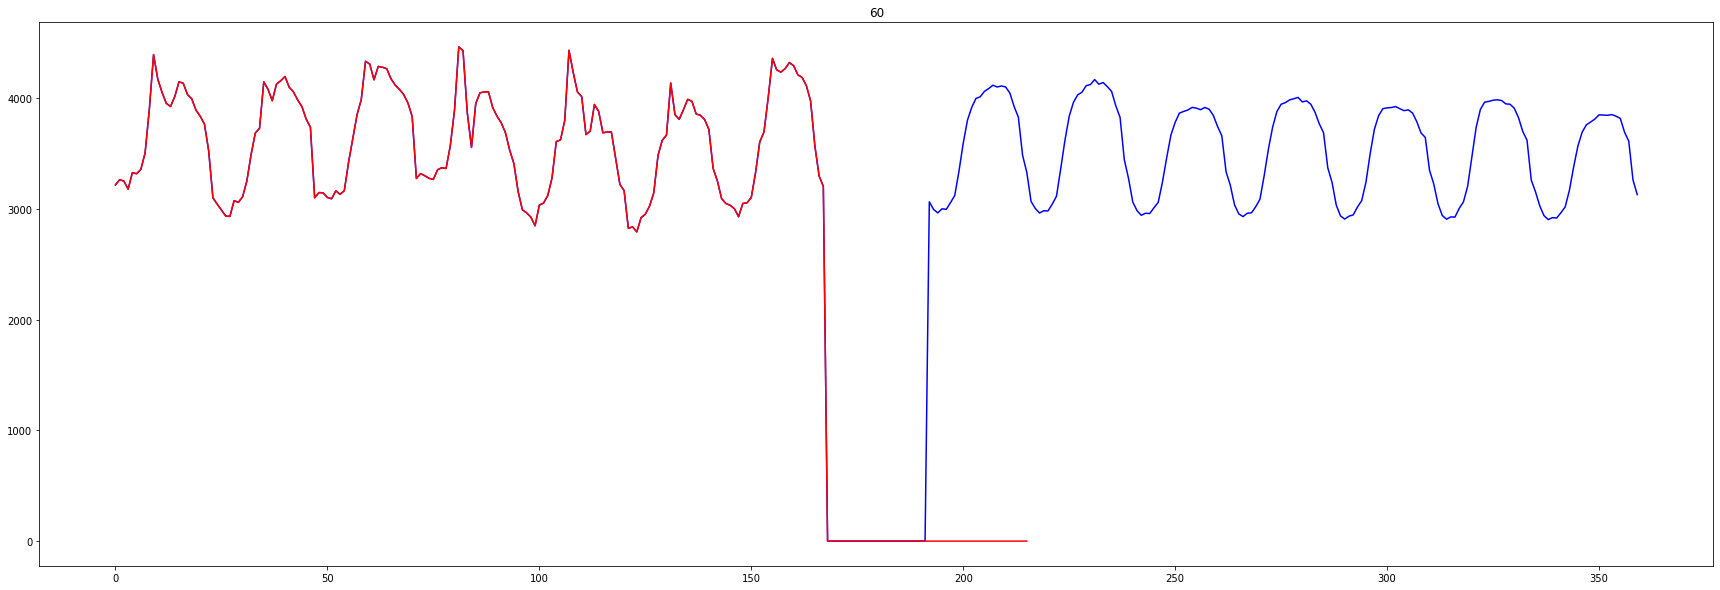

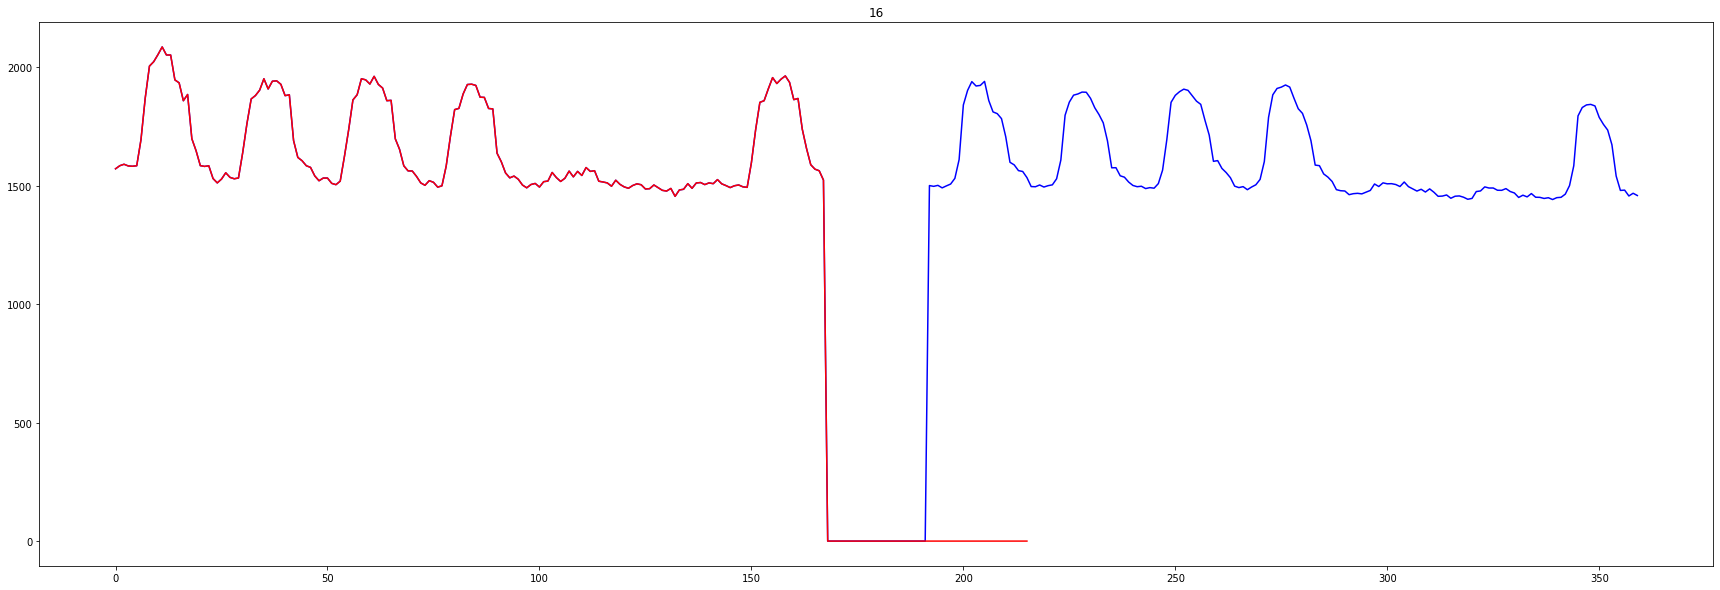

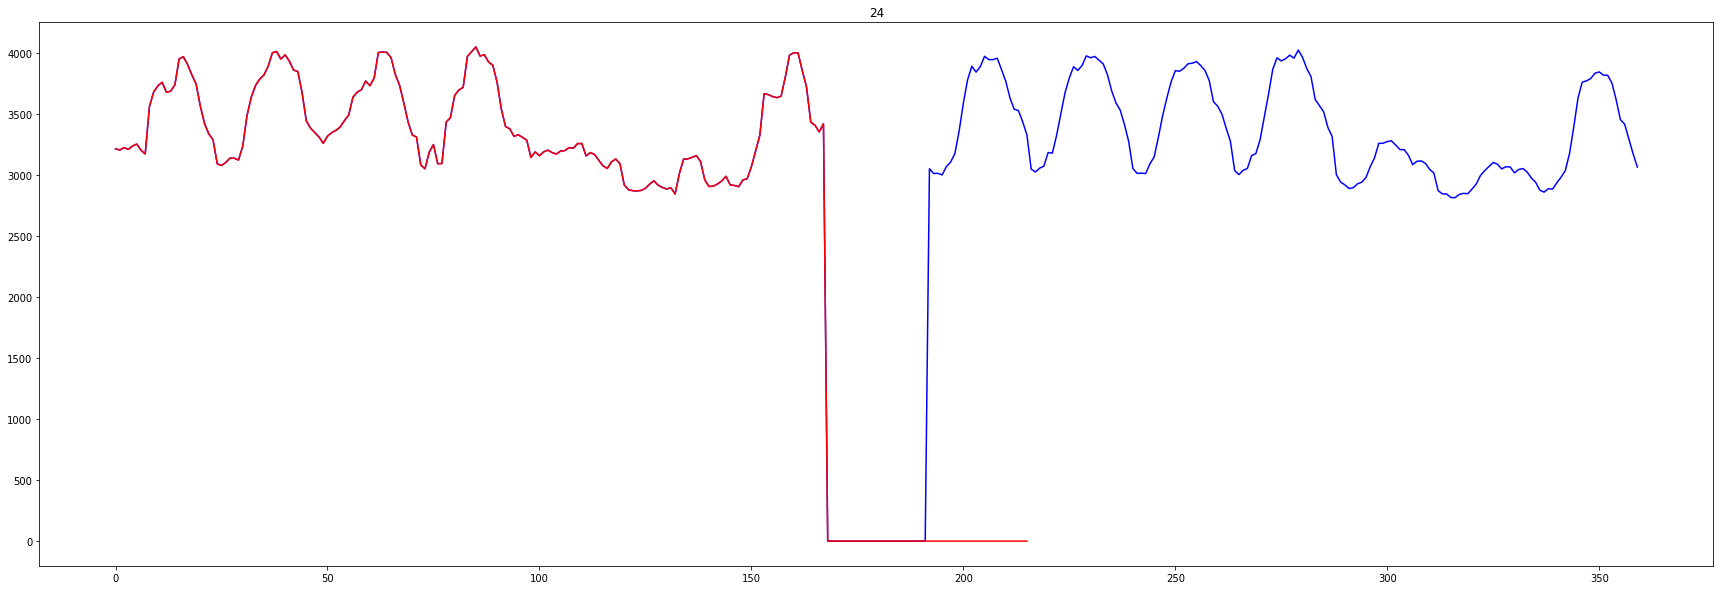

In [4]:
for i in range(len(model_paths)):
    now_dataframe = dataframes[i]
    now_dataframe['num'] = now_dataframe['num'].apply(str)
    now_dataframe['energy_group'] = now_dataframe['energy_group'].apply(str)
    now_dataframe['Week'] = now_dataframe['Week'].apply(str)
    now_dataframe['24Hour'] = now_dataframe['24Hour'].apply(str)
    now_dataframe['holiday'] = now_dataframe['holiday'].apply(str)
    now_dataframe['Weekend'] = now_dataframe['Weekend'].apply(str)
    
    now_best_tft = TemporalFusionTransformer.load_from_checkpoint(model_paths[i])

    for building in group[i]:
        now_building_dataframe = now_dataframe.loc[now_dataframe["num"] == str(building)].copy()
        now_building_dataframe = now_building_dataframe[(-168*2):]

        original = now_building_dataframe.iloc[0:input_length+output_length]["kWH"].tolist()
        prediction = now_building_dataframe.iloc[0:input_length+output_length]["kWH"].tolist()  
        real_prediction = []
        real_prediction_time = now_building_dataframe.iloc[168:]["date_time"].tolist()[:]

        total_cycle = ((len(now_building_dataframe) - input_length - output_length) // output_length) + 1

        for k in range(total_cycle):
            now_start_point = k*output_length

            encoder_data = now_building_dataframe.iloc[now_start_point:now_start_point+input_length].copy()
            decoder_data = now_building_dataframe.iloc[now_start_point+input_length:now_start_point+input_length+output_length].copy()
            new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

            raw_predictions = now_best_tft.predict(new_prediction_data, mode="prediction").numpy().tolist()[0]
            originals = now_building_dataframe.iloc[now_start_point+input_length : now_start_point+input_length+output_length]["kWH"].tolist()

            prediction.extend(raw_predictions)
            real_prediction.extend(raw_predictions)
            original.extend(originals)

            # for next step, change dataframe's original value to predicted value
            for p in range(output_length):
                now_building_dataframe.iloc[now_start_point+input_length+p, now_building_dataframe.columns.get_loc("kWH")] = raw_predictions[p]
            
        if show_graph:
            plt.rcParams["figure.figsize"] = (30,10)
            fig = plt.figure()
            graph = fig.add_subplot(1, 1, 1)
            graph.set_title(f"{building}")
            graph.plot(prediction, color='blue')
            graph.plot(original[:(168+48)], color='red')
            plt.show()


        # 1 2020-08-25 00
        real_prediction = real_prediction[:]

        result = pd.DataFrame({"num_date_time" : ["padding"], "answer" : [999]})
        for k in range(len(real_prediction)):
            temp = pd.DataFrame({"num_date_time" : [f"{building} {real_prediction_time[k][:-6]}"], "answer" : [real_prediction[k]]})
            result = result.append(temp, ignore_index=True)
        result = result.drop(0,axis=0)

        all_result[building-1].append(result)

In [5]:
if result_save:

    complete_result = all_result[0][0]

    for i in range(1,60):
        complete_result = complete_result.append(all_result[i][0], ignore_index=True)

    complete_result.to_csv(f"submission.csv", mode='w', index = False)